In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import library

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Import dataset

In [0]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./test.csv')

In [18]:
df_train.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]

In [19]:
df_test.head()

Id  MSSubClass MSZoning  ...  YrSold  SaleType SaleCondition
0  1461          20       RH  ...    2010        WD        Normal
1  1462          20       RL  ...    2010        WD        Normal
2  1463          60       RL  ...    2010        WD        Normal
3  1464          60       RL  ...    2010        WD        Normal
4  1465         120       RL  ...    2010        WD        Normal

[5 rows x 80 columns]

In [0]:
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

# Data Pre-processing

In [0]:
df = pd.concat([df_train, df_test]).reset_index(drop=True).copy()

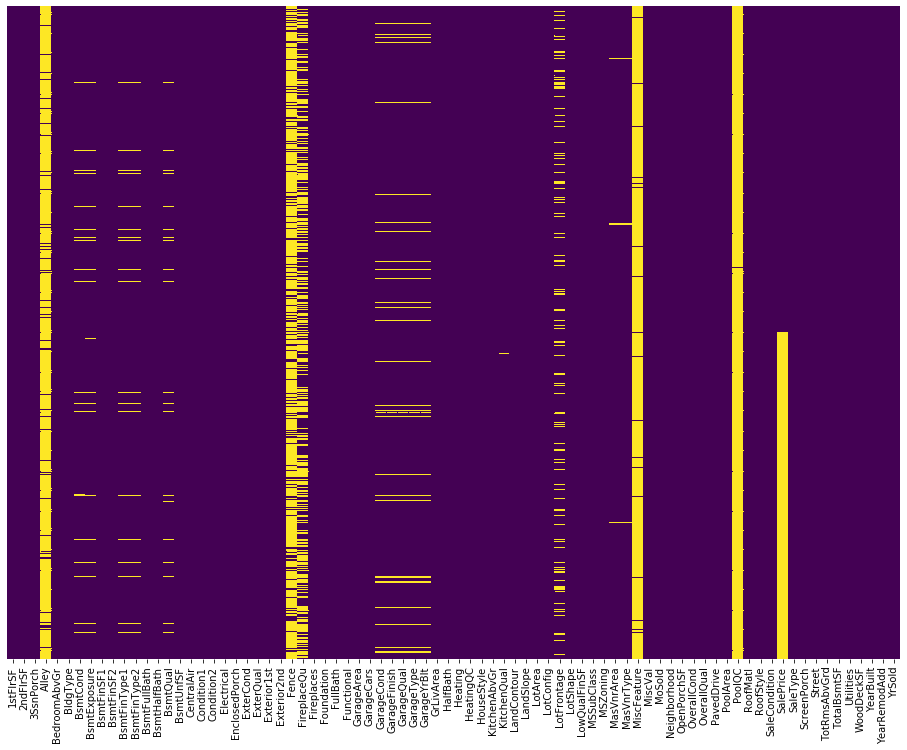

In [22]:
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

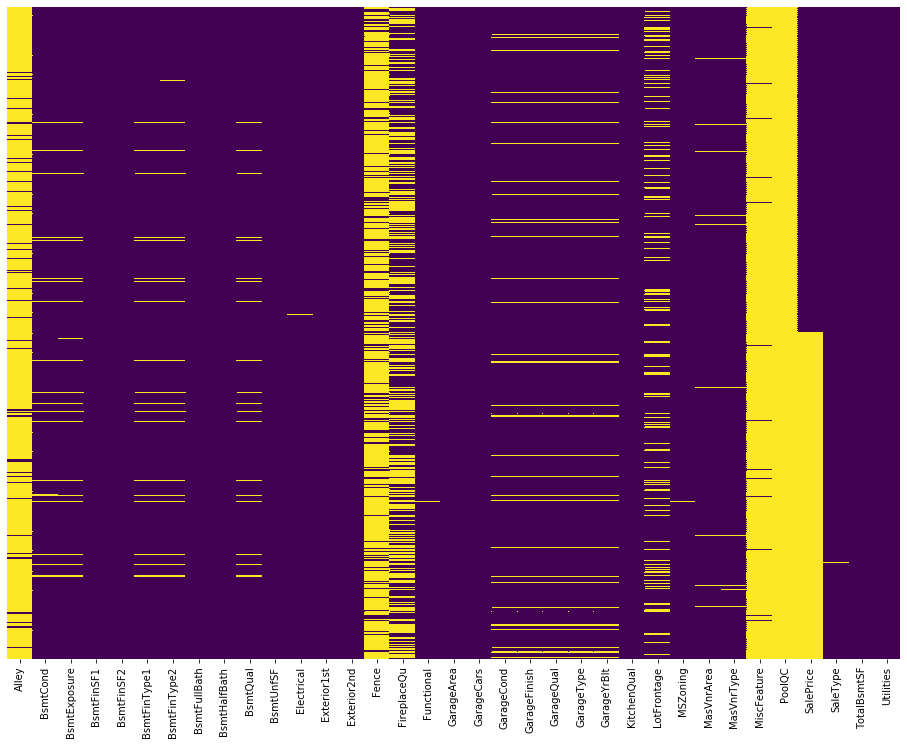

In [23]:
f, ax = plt.subplots(figsize=(16, 12))
col_missing_data = df.columns[df.isnull().sum() > 0].tolist()
sns.heatmap(df[col_missing_data].isnull(), cbar=False, yticklabels=False, cmap='viridis')

In [24]:
print(col_missing_data)

['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF', 'Utilities']


In [25]:
df['Electrical'].value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [26]:
df[df['GarageQual'].isnull()][['GarageQual', 'GarageArea','GarageCars']]

GarageQual  GarageArea  GarageCars
39          NaN         0.0         0.0
48          NaN         0.0         0.0
78          NaN         0.0         0.0
88          NaN         0.0         0.0
89          NaN         0.0         0.0
...         ...         ...         ...
2893        NaN         0.0         0.0
2909        NaN         0.0         0.0
2913        NaN         0.0         0.0
2914        NaN         0.0         0.0
2917        NaN         0.0         0.0

[159 rows x 3 columns]

In [27]:
df[df['GarageArea'].isnull() | df['GarageCars'].isnull()][['GarageQual', 'GarageArea','GarageCars']]

GarageQual  GarageArea  GarageCars
2576        NaN         NaN         NaN

In [28]:
## Data that can be filled based on Domain knowledge
Fill_with_none = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                  'BsmtFinType2', 'BsmtQual', 'Fence', 'FireplaceQu',
                  'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
                  'MiscFeature', 'PoolQC', 'MasVnrType', 'Exterior2nd'
                 ] 

Fill_with_zero = [ 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                  'BsmtFullBath', 'BsmtHalfBath','GarageArea', 'GarageCars', 
                  'GarageYrBlt', 'MasVnrArea', 'LotFrontage'
                 ]

Fill_with_mode = [ 'Electrical', 'Exterior1st',  'Functional', 
                  'KitchenQual',  'MSZoning', 'SaleType', 'Utilities'
                 ]

for col in Fill_with_none:
    df[col].fillna("None", inplace=True)
    df_test[col].fillna("None", inplace=True)
    df_train[col].fillna("None", inplace=True)

for col in Fill_with_zero:
    df[col].fillna(0, inplace=True)
    df_test[col].fillna(0, inplace=True)
    df_train[col].fillna(0, inplace=True)

for col in Fill_with_mode:
    mode = df[col].value_counts().idxmax()
    df[col].fillna(mode, inplace=True)
    df_test[col].fillna(mode, inplace=True)
    df_train[col].fillna(mode, inplace=True)

df.columns[df.isnull().sum() > 0].tolist()

['SalePrice']

# Exploratory Data Analysis

## Numerical

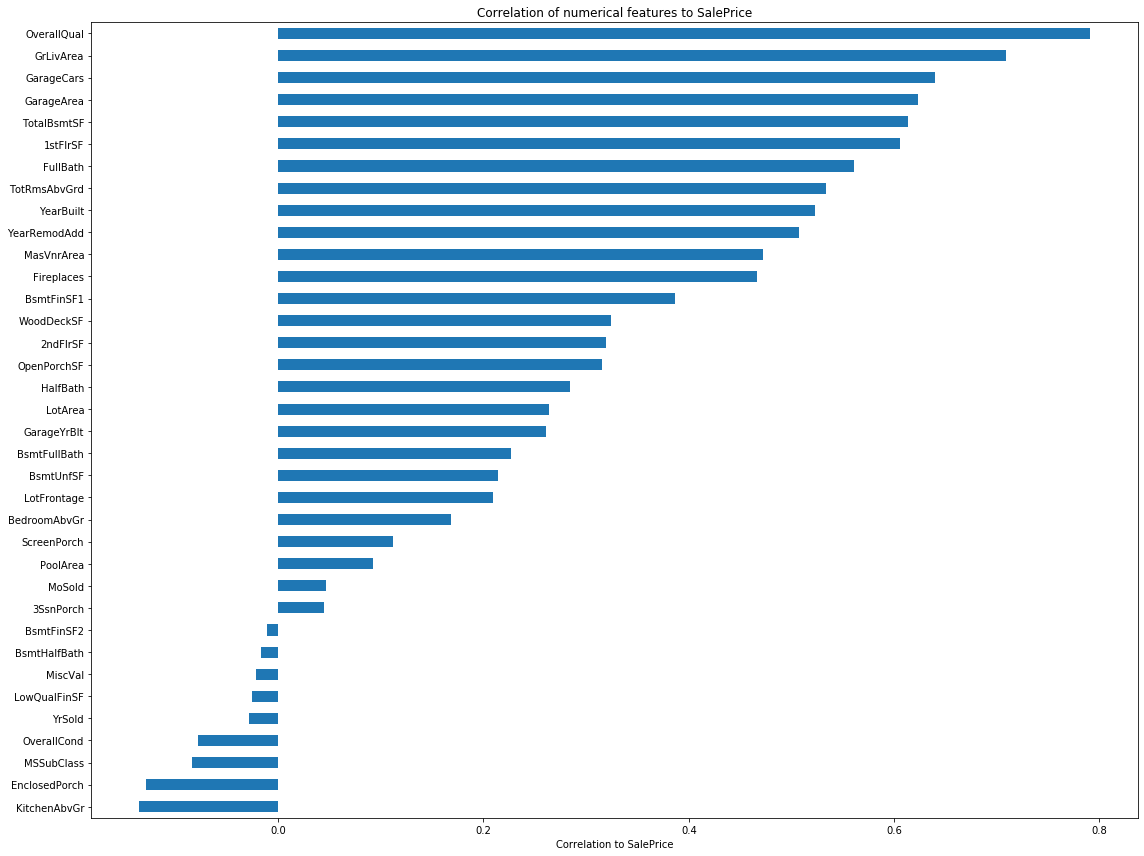

In [29]:
plt.figure(figsize=(16,12));
corr = df_train.corr()['SalePrice']
corr.sort_values(ascending=True)[:-1].plot(kind="barh")

plt.title("Correlation of numerical features to SalePrice")
plt.xlabel("Correlation to SalePrice")
plt.tight_layout()
plt.show()

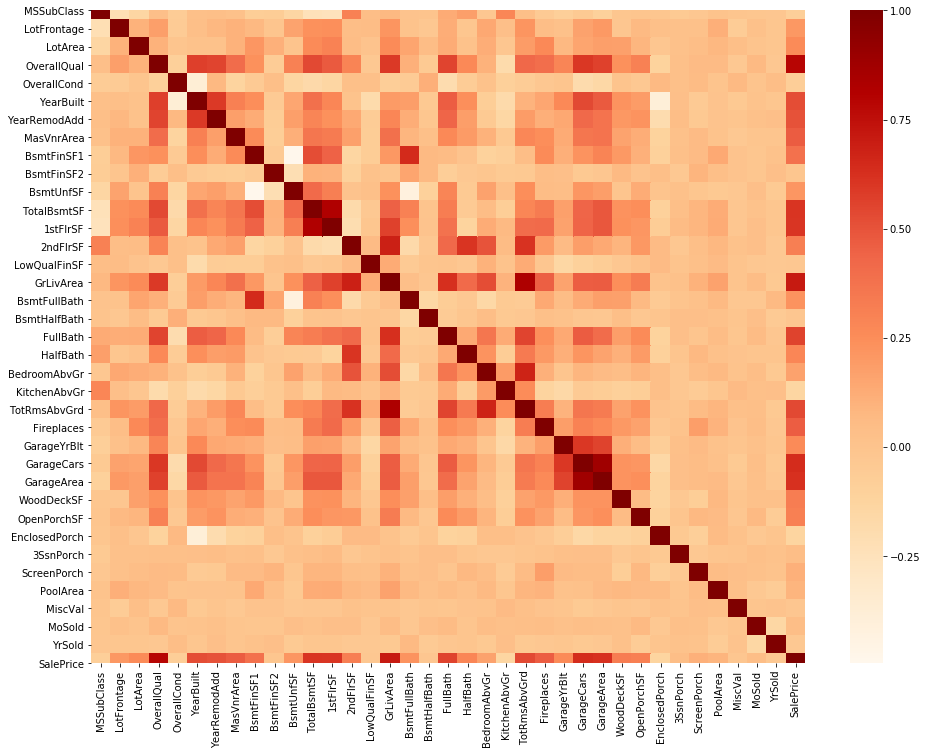

In [30]:
plt.figure(figsize=(16,12));
sns.heatmap(df_train.corr(), cmap = 'OrRd')

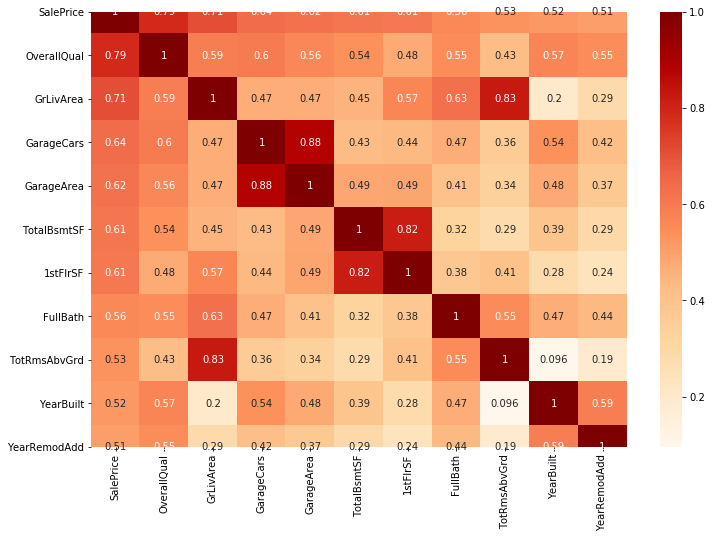

In [31]:
high_corr = df_train.corr()['SalePrice'][(abs(df_train.corr()['SalePrice']) > 0.5)].sort_values(ascending = False)

plt.figure(figsize=(12,8));
sns.heatmap(df_train[high_corr.index].corr(), annot=True, cbar=True, cmap = 'OrRd')

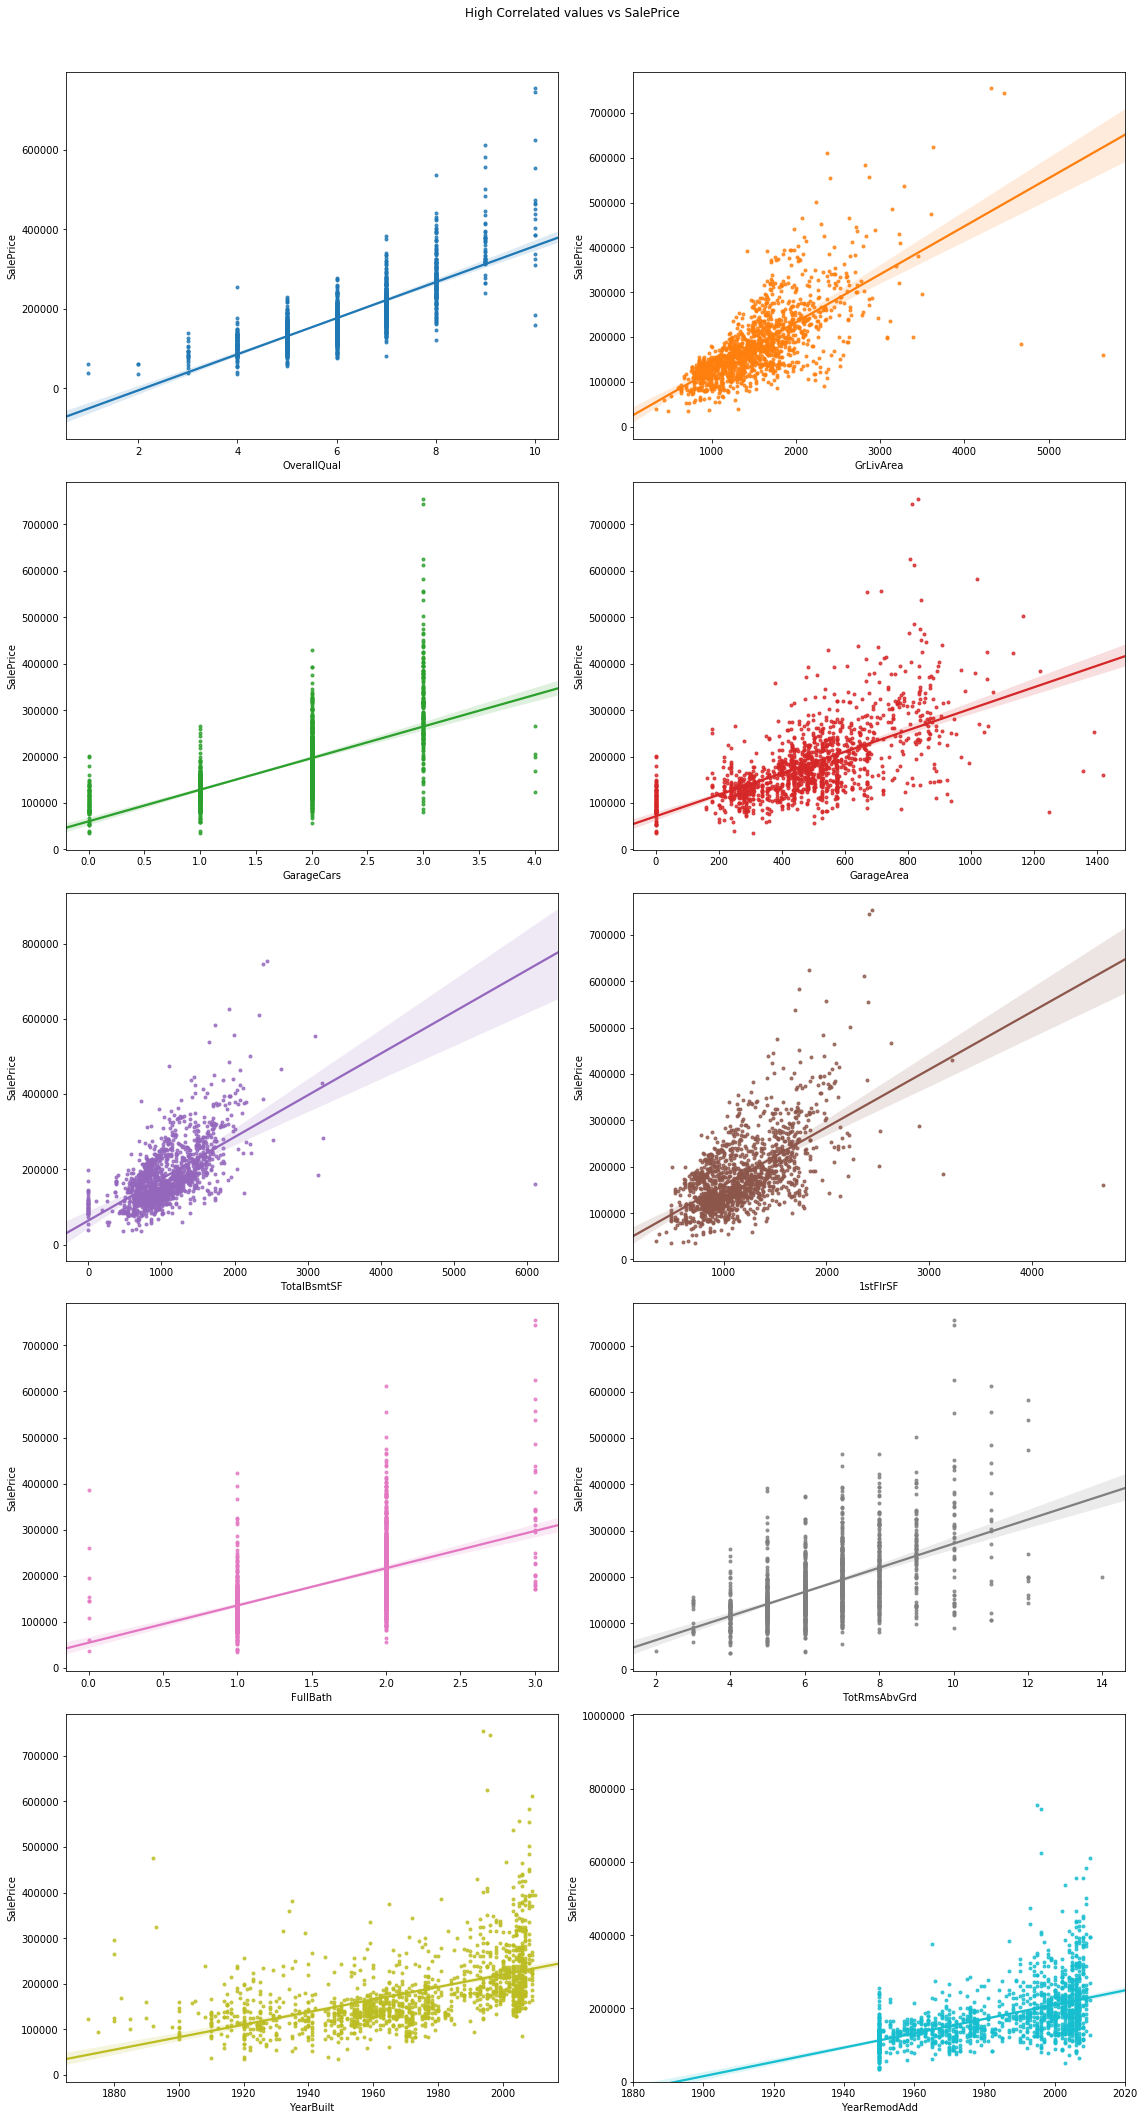

In [32]:
fig, ax = plt.subplots(5, 2, figsize=(16,30))

for idx,col in enumerate(high_corr[1:].index):
    sns.regplot(x=df_train[col], y=df_train["SalePrice"], marker='.', ax=ax[idx//2, idx%2]) 

ax[4,1].set_ylim(0,)
ax[4,1].set_xlim(1880, 2020)

fig.suptitle('High Correlated values vs SalePrice')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

In [0]:
df_numerical = df_train.select_dtypes("number")
num_list = df_numerical.columns.tolist()

In [0]:
for feat in high_corr.index.tolist():
    num_list.remove(feat)

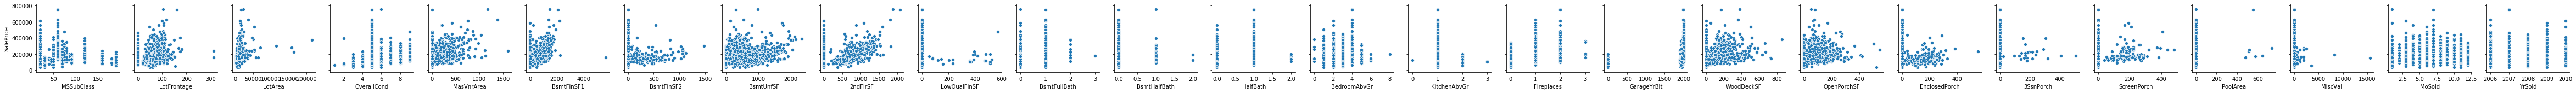

In [35]:
sns.pairplot(data=df_train, x_vars=num_list, y_vars = "SalePrice")

### Numerical

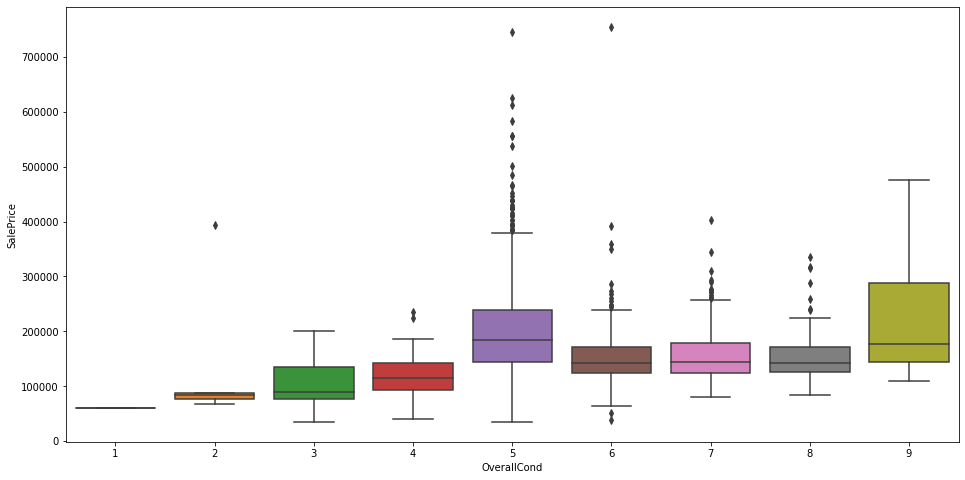

In [36]:
plt.figure(figsize=(16,8));
sns.boxplot(x=df_train['OverallCond'], y=df_train['SalePrice'])

## Categorical

In [37]:
cat_col = df_train.select_dtypes(exclude=np.number).columns.tolist()
print(cat_col)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


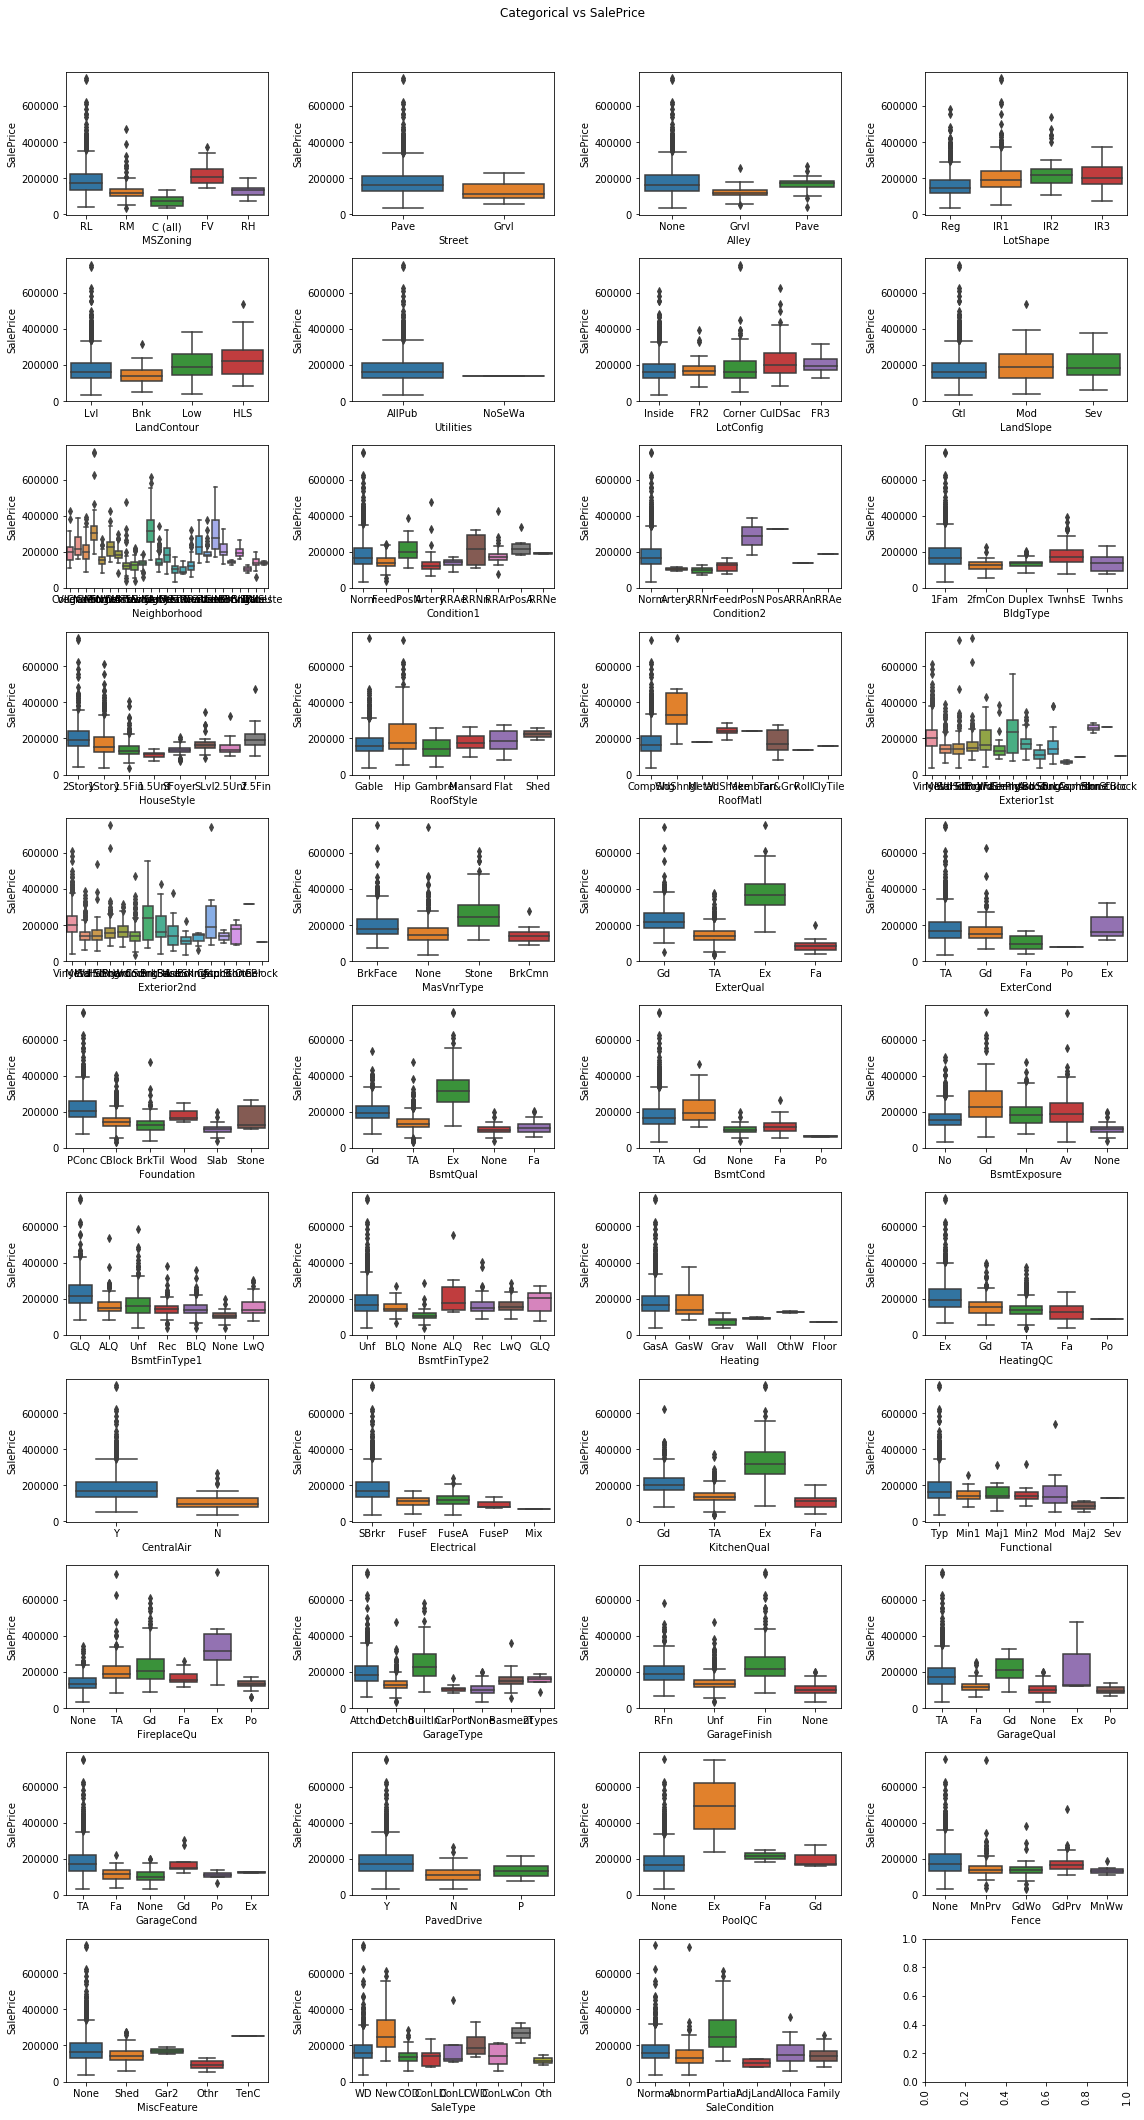

In [38]:
fig, ax = plt.subplots(11, 4, figsize=(16,30))

for idx,col in enumerate(cat_col):
    sns.boxplot(x=df_train[col], y=df_train["SalePrice"], ax=ax[idx//4, idx%4]) 
plt.xticks(rotation=90)
fig.suptitle('Categorical vs SalePrice')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

### Road Conditions

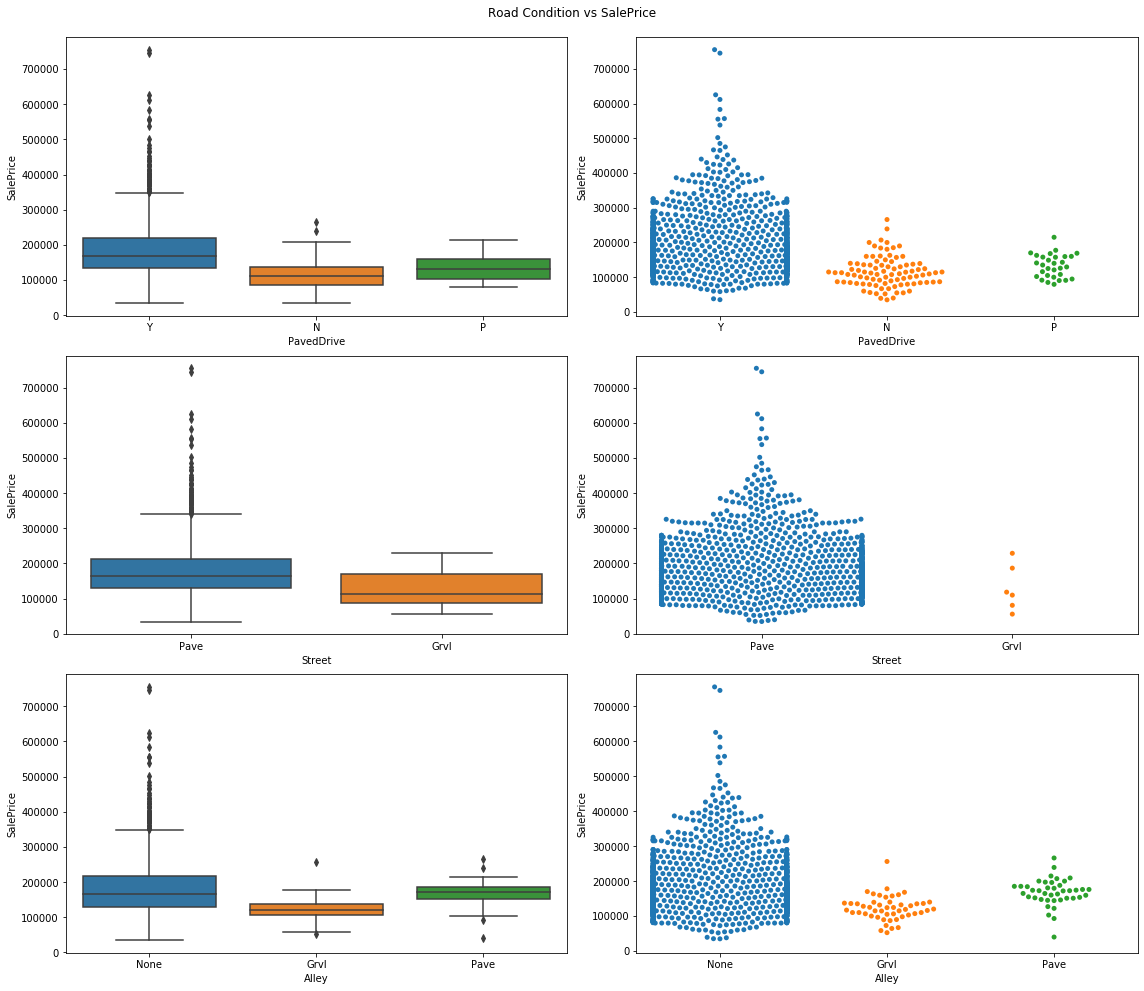

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(16,14))

Paved = ['PavedDrive', 'Street', 'Alley']

for idx,col in enumerate(Paved):
    sns.boxplot(x=df_train[col], y=df_train["SalePrice"], ax=ax[idx, 0]) 
    sns.swarmplot(x=df_train[col], y=df_train["SalePrice"], ax=ax[idx, 1]) 

fig.suptitle('Road Condition vs SalePrice')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

### Lot Condition

<Figure size 1152x576 with 0 Axes>

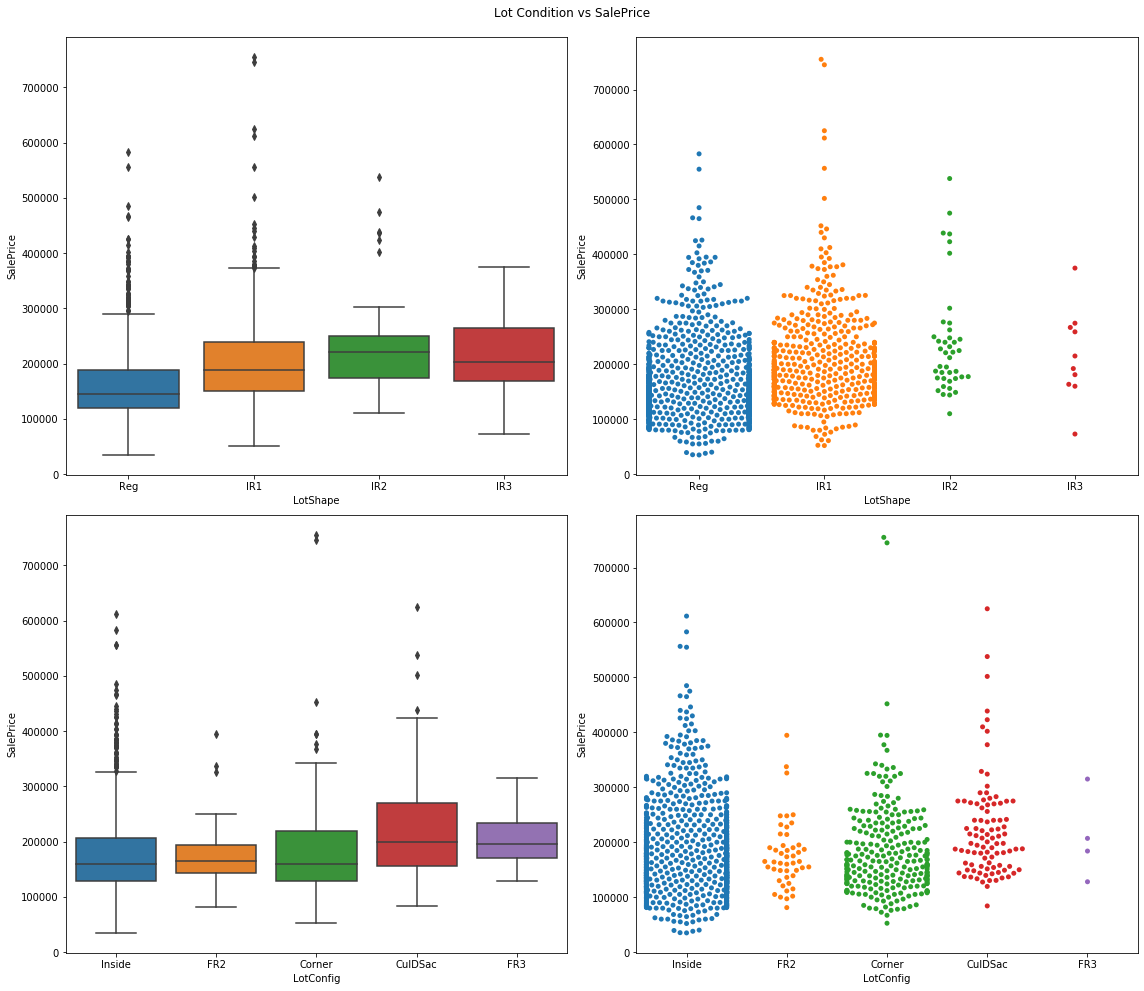

In [40]:
plt.figure(figsize=(16,8));

fig, ax = plt.subplots(2, 2, figsize=(16,14))

Lot = ['LotShape', 'LotConfig']
 
for idx,col in enumerate(Lot):
    sns.boxplot(x=df_train[col], y=df_train["SalePrice"], ax=ax[idx, 0]) 
    sns.swarmplot(x=df_train[col], y=df_train["SalePrice"], ax=ax[idx, 1]) 

fig.suptitle('Lot Condition vs SalePrice')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

### Garage

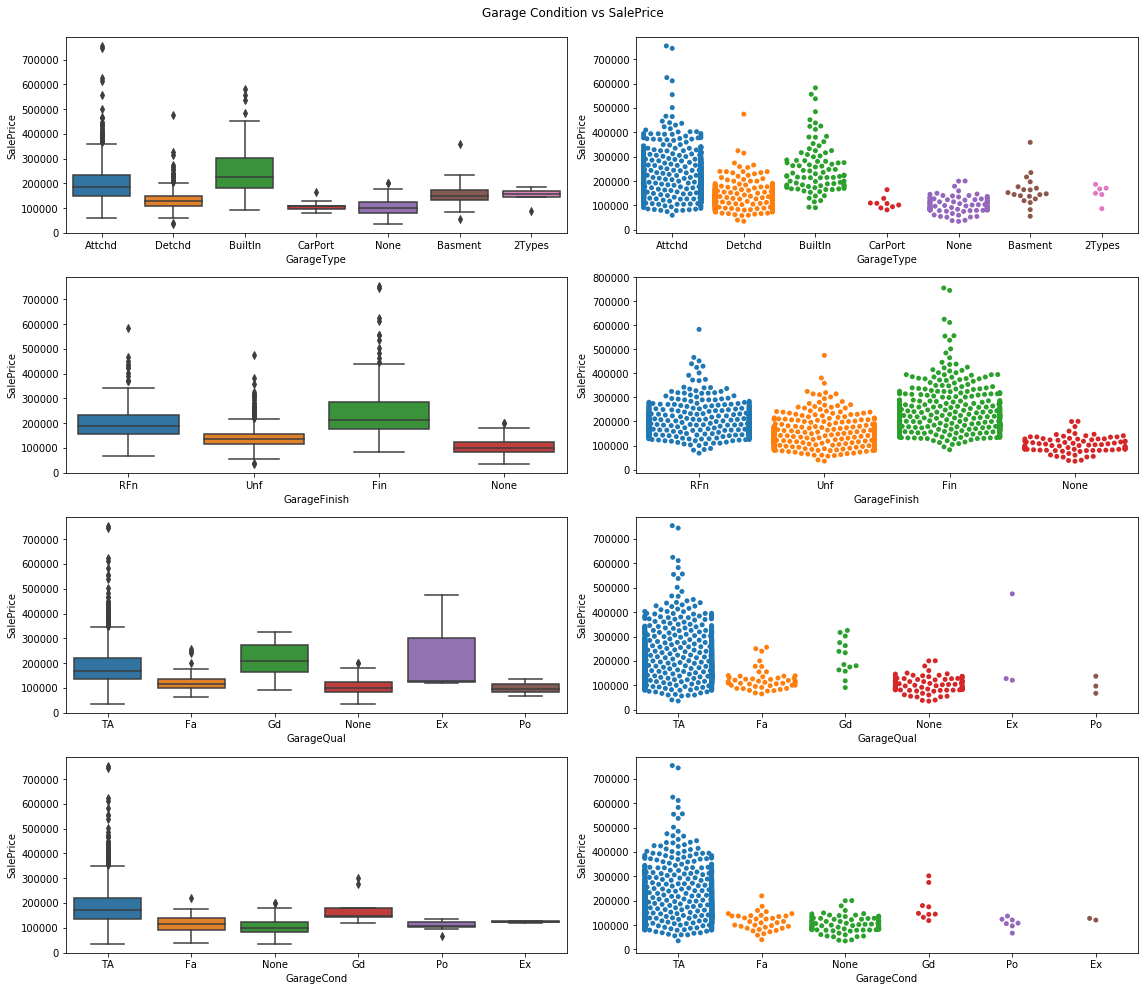

In [41]:
fig, ax = plt.subplots(4, 2, figsize=(16,14))

Garage = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

for idx,col in enumerate(Garage):
    sns.boxplot(x=df_train[col], y=df_train["SalePrice"], ax=ax[idx, 0]) 
    sns.swarmplot(x=df_train[col], y=df_train["SalePrice"], ax=ax[idx, 1]) 

fig.suptitle('Garage Condition vs SalePrice')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

### Bsmt

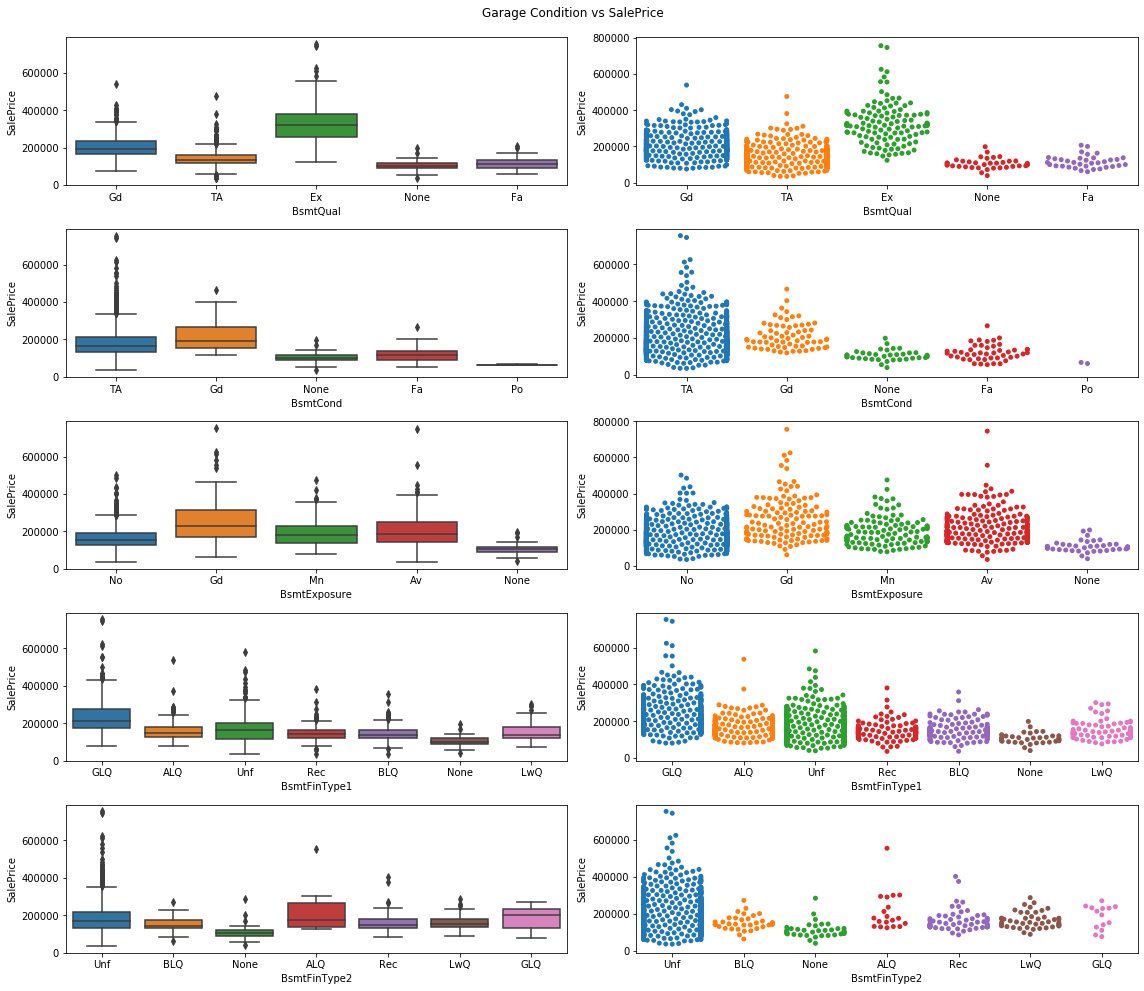

In [42]:
fig, ax = plt.subplots(5, 2, figsize=(16,14))

Basement = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for idx,col in enumerate(Basement):
    sns.boxplot(x=df_train[col], y=df_train["SalePrice"], ax=ax[idx, 0]) 
    sns.swarmplot(x=df_train[col], y=df_train["SalePrice"], ax=ax[idx, 1]) 

fig.suptitle('Garage Condition vs SalePrice')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

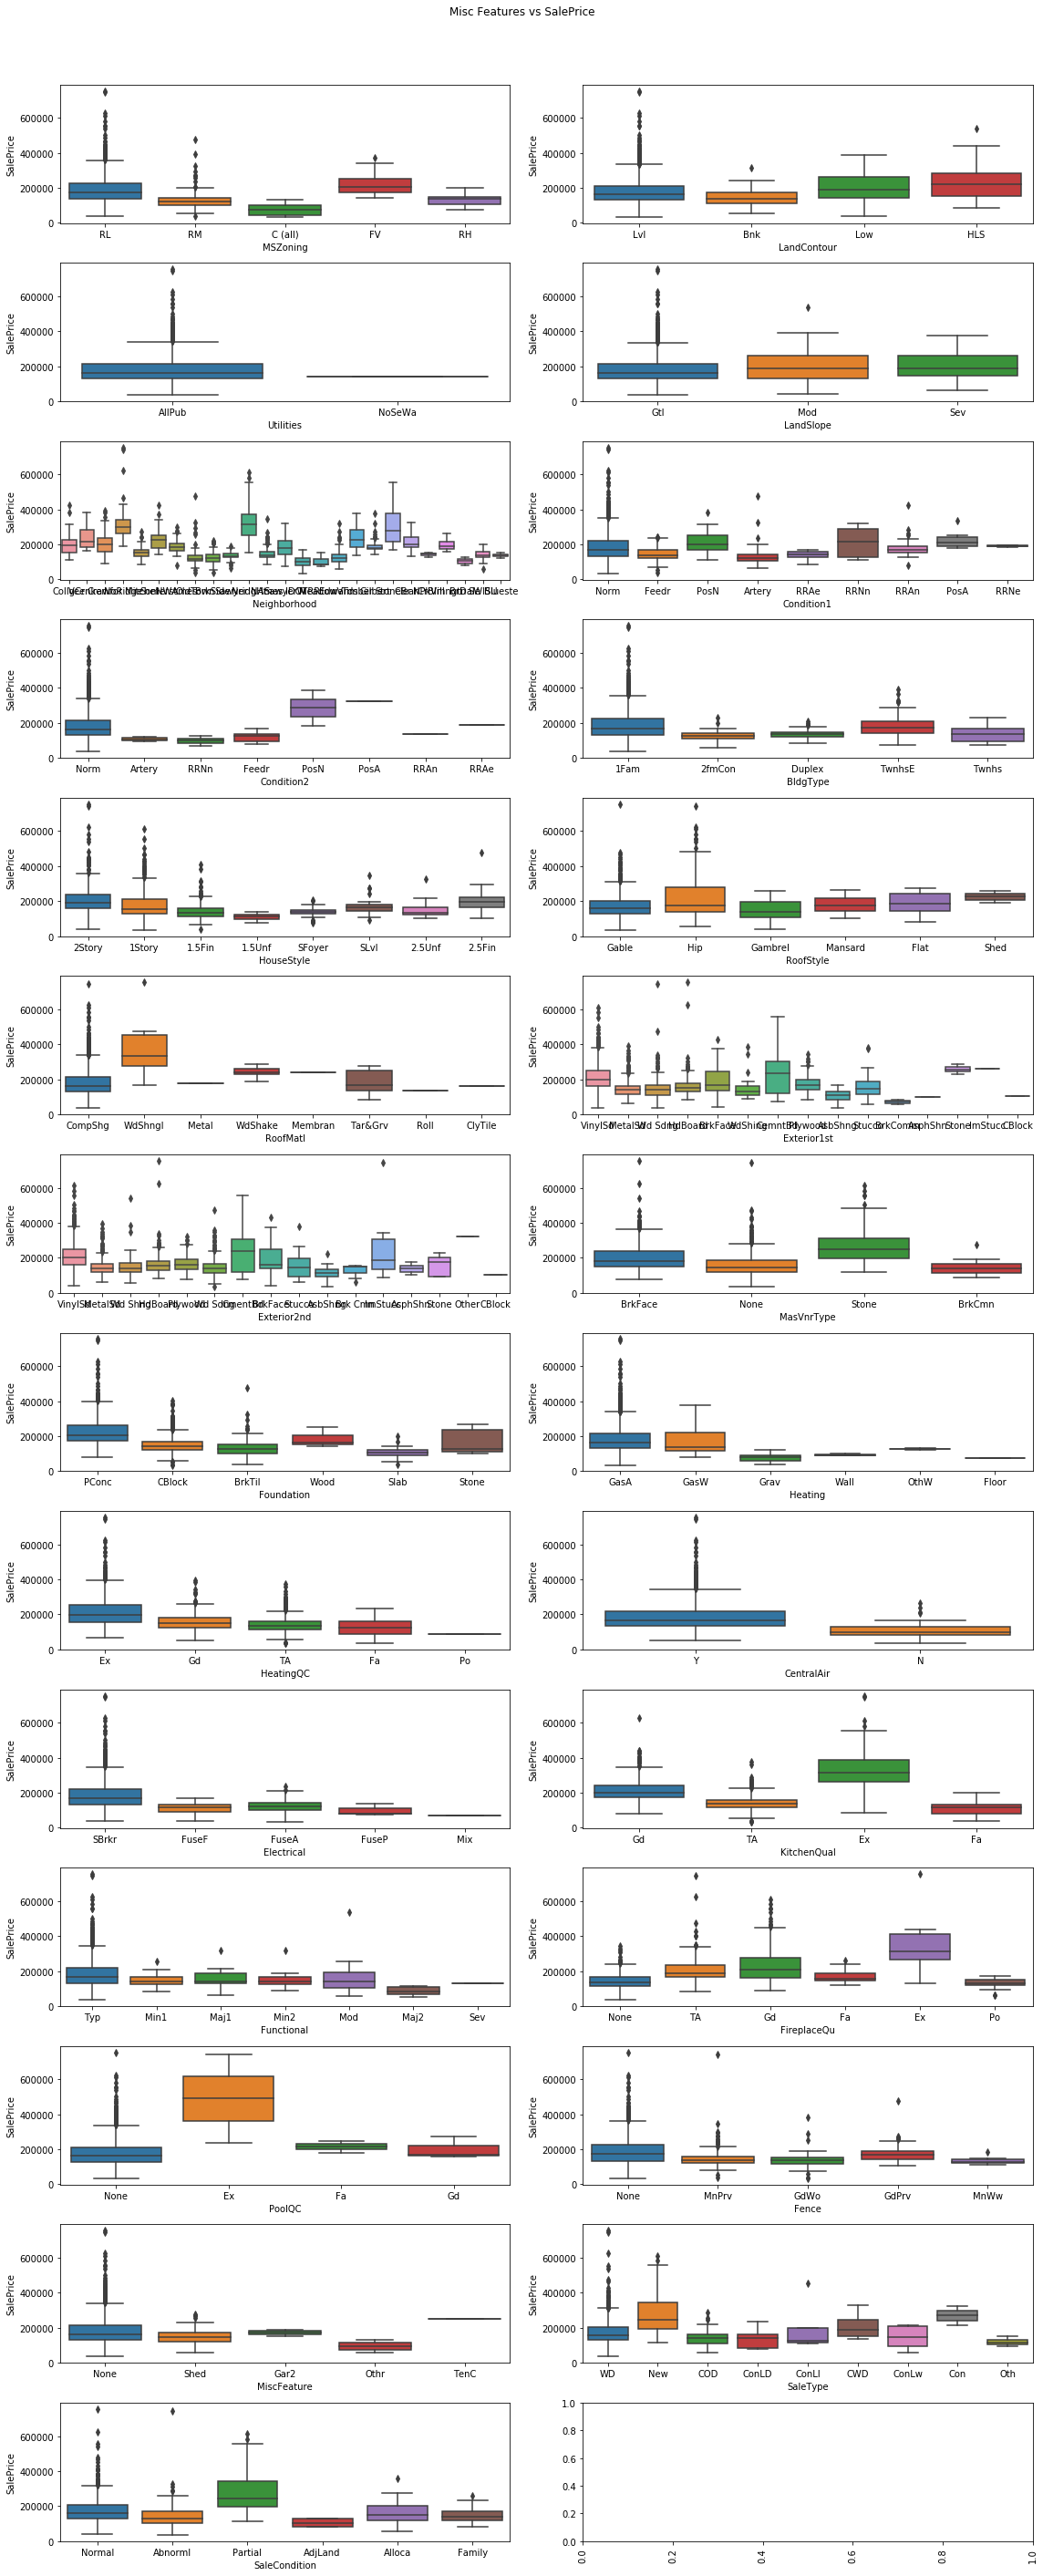

In [43]:
fig, ax = plt.subplots(14, 2, figsize=(16,40))

Misc = ['MSZoning', 'LandContour', 'Utilities', 'LandSlope', 'Neighborhood', 
     'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
     'Exterior1st', 'Exterior2nd', 'MasVnrType',  'Foundation', 'Heating', 
     'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
     'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

for idx,col in enumerate(Misc):
    sns.boxplot(x=df_train[col], y=df_train["SalePrice"], ax=ax[idx//2, idx%2]) 
    plt.xticks(rotation=90)
fig.suptitle('Misc Features vs SalePrice')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

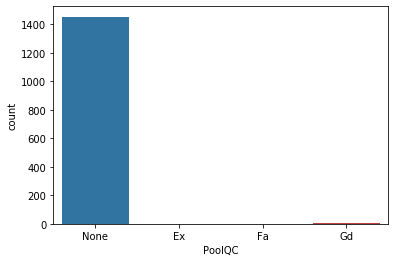

In [44]:
sns.countplot(df_train['PoolQC'])

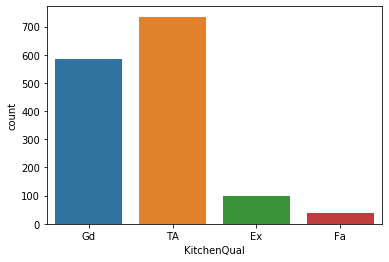

In [45]:
sns.countplot(df_train['KitchenQual'])

##### Porch

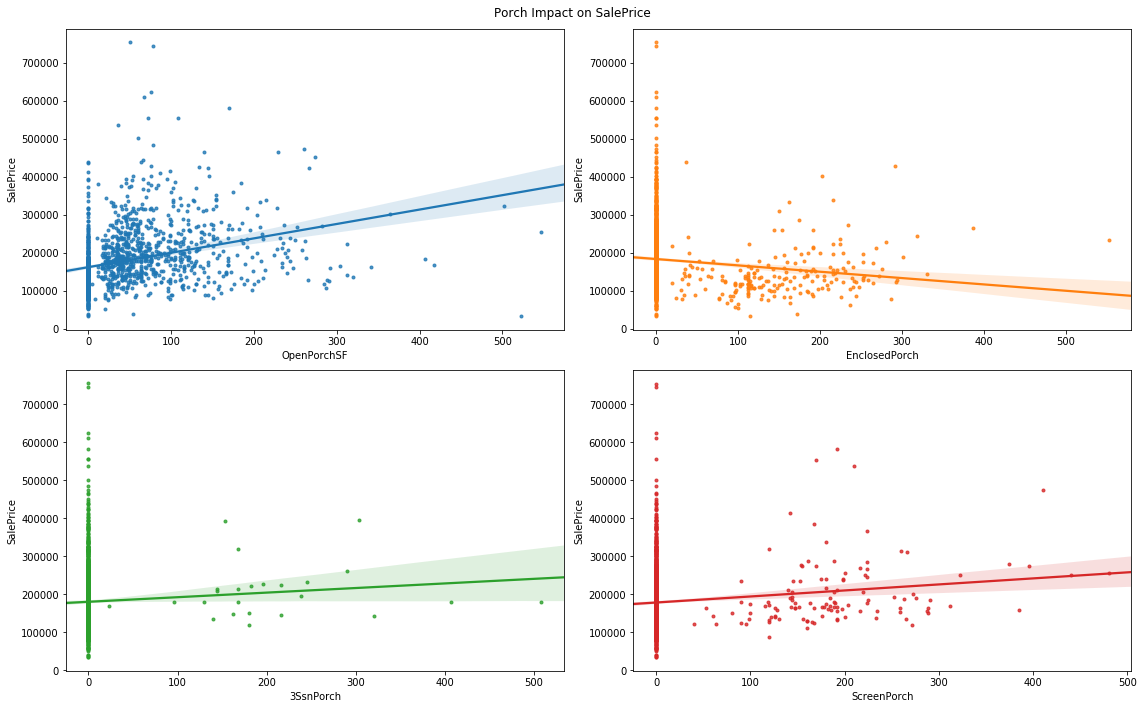

In [46]:
porchs = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

fig, ax = plt.subplots(2, 2, figsize=(16,10))

numerical = df_train.select_dtypes(include=np.number).columns.tolist()
for idx,col in enumerate(porchs):
    sns.regplot(x=df_train[col], y=df_train["SalePrice"], marker='.', ax=ax[idx//2, idx%2])  

fig.suptitle('Porch Impact on SalePrice')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

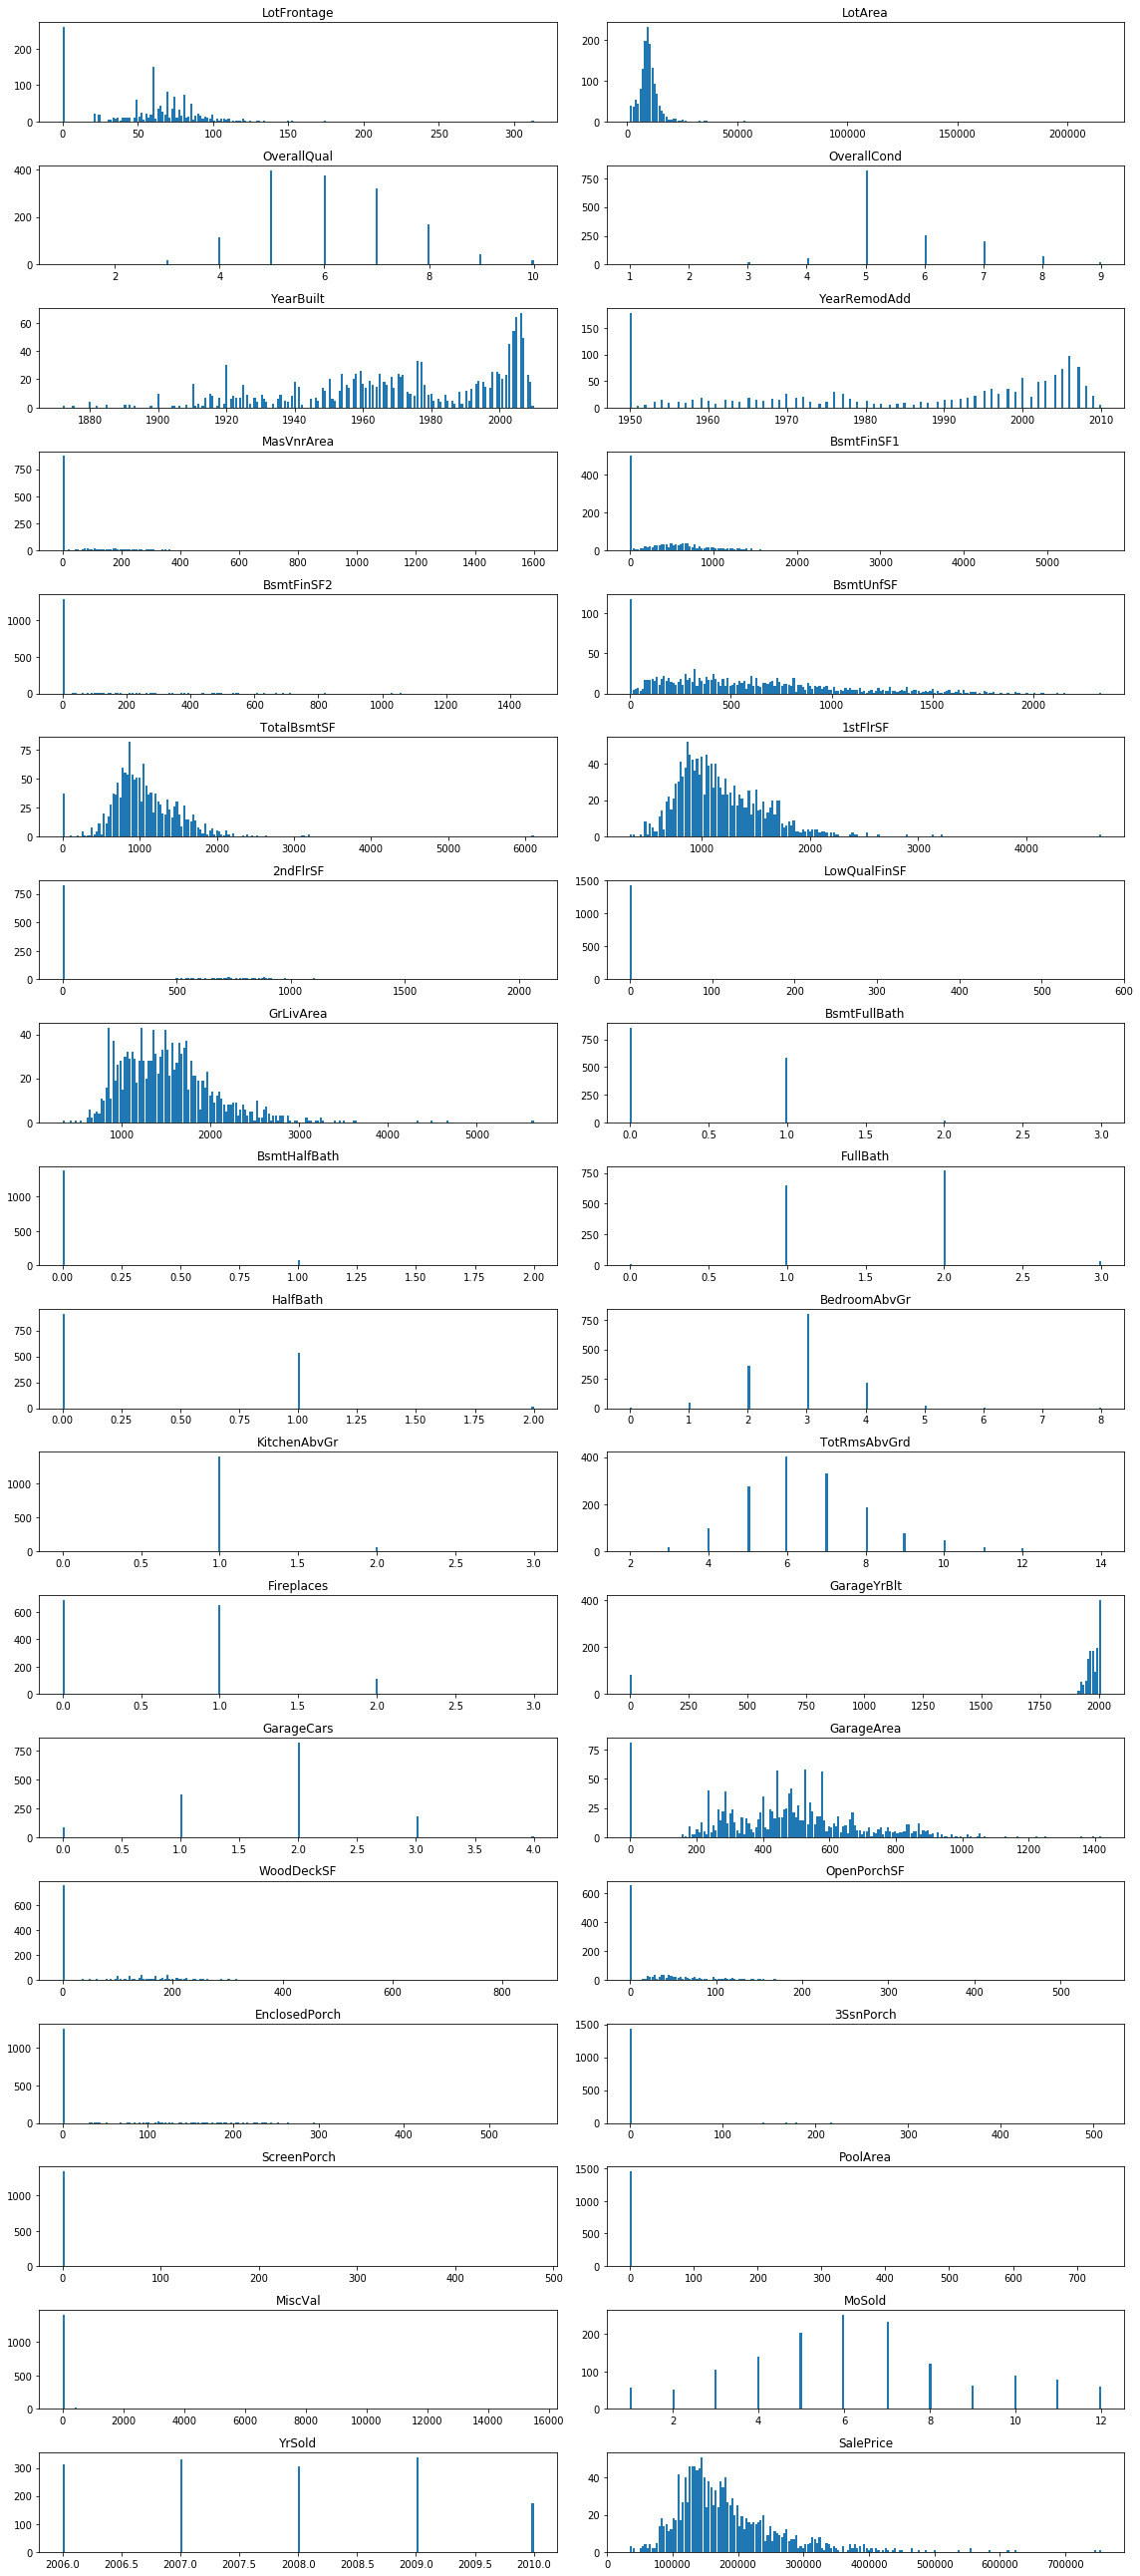

In [47]:
fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(16,36))

for idx, col in enumerate(df_numerical.columns[1:]):
    df_numerical[col].plot(kind="hist", bins=200, rwidth=.9, title=col, ax=axes[idx//2, idx%2])
    ax=axes[idx//2, idx%2].yaxis.label.set_visible(False)

plt.tight_layout()
plt.show()

## Sale Price Analysis

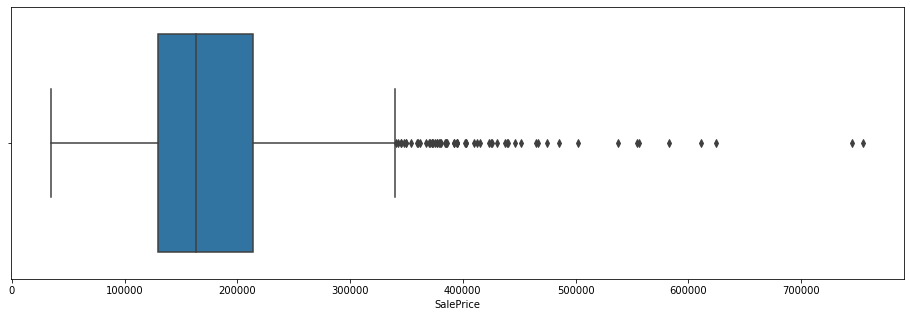

In [48]:
f, ax = plt.subplots(figsize=(16, 5))
sns.boxplot(df['SalePrice'])

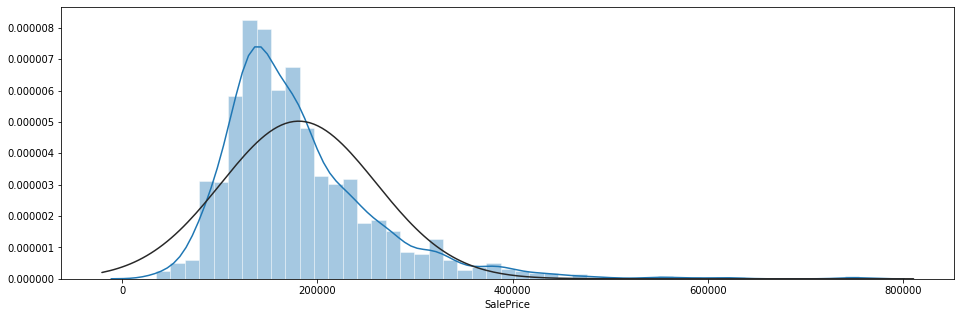

In [49]:
f, ax = plt.subplots(figsize=(16, 5))
sns.set_style('whitegrid')
sns.distplot(df_train["SalePrice"],fit=norm)

Text(0.5, 1.0, 'Probability plot: SalePrice')

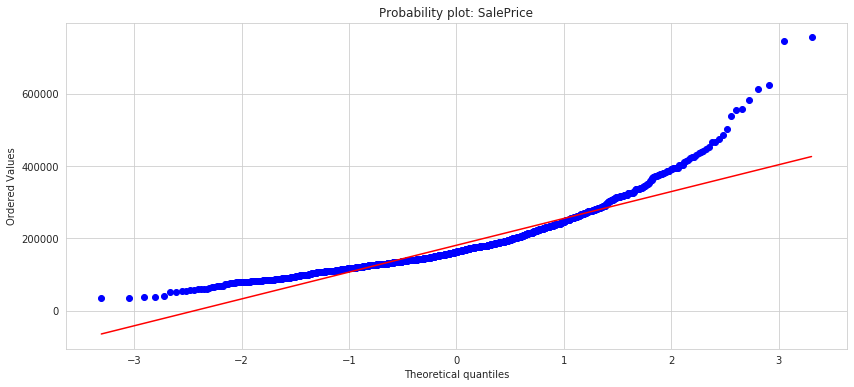

In [50]:
plt.figure(figsize=(14,6))
stats.probplot(df_train['SalePrice'], plot=plt)
plt.title("Probability plot: SalePrice")

In [51]:
# calculate percentiles and IQR
q25 = np.percentile(df_train.SalePrice, 25)
q75 = np.percentile(df_train.SalePrice, 75)
iqr = q75 - q25

# calculate normal and extreme upper and lower cut off
cut_off = iqr * 3
lower_extreme_outlier = q25 - cut_off 
upper_extreme_outlier = q75 + cut_off

print(f'Percentiles:\n25th  =  {q25}\n75th  =  {q75}\n\nIQR   =   {iqr}\nlower = {lower_extreme_outlier}\nupper =  {upper_extreme_outlier}')

Percentiles:
25th  =  129975.0
75th  =  214000.0

IQR   =   84025.0
lower = -122100.0
upper =  466075.0


In [52]:
df_train[df_train.SalePrice > upper_extreme_outlier]

MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
178           20       RL         63.0  ...       New       Partial    501837
185           75       RM         90.0  ...        WD        Normal    475000
440           20       RL        105.0  ...        WD        Normal    555000
691           60       RL        104.0  ...        WD        Normal    755000
769           60       RL         47.0  ...        WD        Normal    538000
798           60       RL        104.0  ...       New       Partial    485000
803           60       RL        107.0  ...       New       Partial    582933
898           20       RL        100.0  ...       New       Partial    611657
1046          60       RL         85.0  ...       New       Partial    556581
1169          60       RL        118.0  ...        WD        Normal    625000
1182          60       RL        160.0  ...        WD       Abnorml    745000
1373          20       RL          0.0  ...        WD        Normal    466500

[12 rows x 80 columns]

In [53]:
print("SalePrice:")
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

SalePrice:
Skewness: 1.882876
Kurtosis: 6.536282


Text(0.5, 1.0, 'Probability plot: SalePrice')

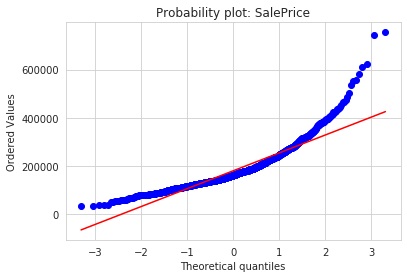

In [54]:
stats.probplot(df_train['SalePrice'], plot=plt)
plt.title("Probability plot: SalePrice")

In [55]:
LogSalePrice = df_train["SalePrice"].apply(np.log)
LogSalePrice.name = 'LogSalePrice'
print("Log SalePrice:")
print("Skewness: %f" % LogSalePrice.skew())
print("Kurtosis: %f" % LogSalePrice.kurt())

Log SalePrice:
Skewness: 0.121335
Kurtosis: 0.809532


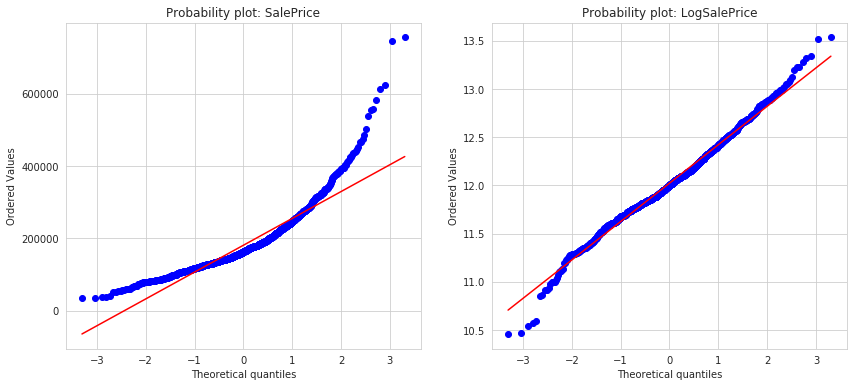

In [56]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
stats.probplot(df_train['SalePrice'], plot=plt)
plt.title("Probability plot: SalePrice")

plt.subplot(1, 2, 2)
stats.probplot(LogSalePrice, plot=plt)
plt.title("Probability plot: LogSalePrice")
plt.show()

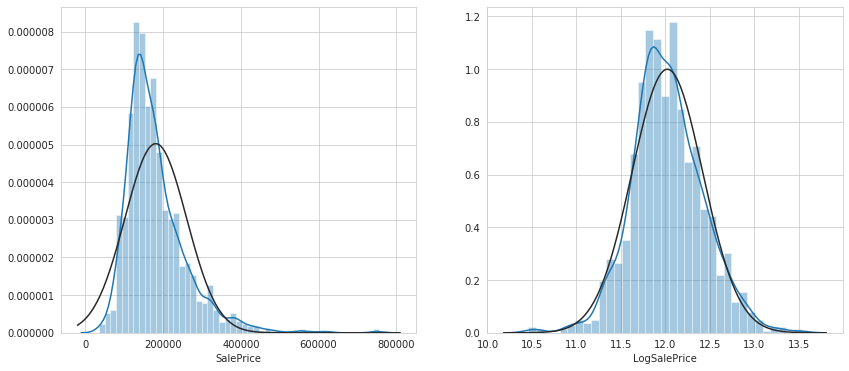

In [57]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.set_style('whitegrid')
sns.distplot(df_train["SalePrice"],fit=norm)

plt.subplot(1, 2, 2)
sns.set_style('whitegrid')
sns.distplot(LogSalePrice,fit=norm)

In [58]:
df_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# Data Pre-processing

## Encoding

In [59]:
categoricals = df.select_dtypes(exclude=np.number).columns.tolist()
print(categoricals)

['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']


In [0]:
Norminal = ['MSZoning',  'LandContour', 'Heating',  'Electrical',  
            'LotConfig',  'Neighborhood', 'Condition1', 'Condition2', 
            'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
            'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',  
            'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']

In [0]:
Ordinal = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 
           'BsmtFinType1', 'LandSlope', 'LotShape', 'PavedDrive', 
           'PoolQC', 'KitchenQual', 'Street', 'Alley', 
           'HeatingQC', 'FireplaceQu', 'GarageQual', 'GarageCond', 
           'GarageFinish', 'Fence', 'Utilities', 'CentralAir',
           'ExterQual', 'ExterCond', 'Functional']

### Ordinal

In [0]:
for col in ['KitchenQual', 'BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageCond', 'GarageQual']:
    df[col] = df[col].replace(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], np.arange(0,6).tolist()).astype(int)

for col in ['ExterQual', 'ExterCond', 'HeatingQC']:
    df[col] = df[col].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], np.arange(0,5).tolist()).astype(int)

for col in ['BsmtFinType1', 'BsmtFinType2']:
    df[col] = df[col].replace(['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], np.arange(0,7).tolist()).astype(int)
    
df['Street'] = df.Street.replace(['Grvl', 'Pave'], np.arange(0,2).tolist()).astype(int)
df['Alley'] = df.Alley.replace(['None', 'Grvl', 'Pave'], np.arange(0,3).tolist()).astype(int)
df['PoolQC'] = df.PoolQC.replace(['None', 'Fa', 'TA', 'Gd', 'Ex'], np.arange(0,5).tolist()).astype(int)
df['Functional'] = df.Functional.replace(['None', 'Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], np.arange(0,9).tolist()).astype(int)
df['BsmtExposure'] = df.BsmtExposure.replace(['None', 'No', 'Mn', 'Av', 'Gd'], np.arange(0,5).tolist()).astype(int)
df['Fence'] = df.Fence.replace(['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], np.arange(0,5).tolist()).astype(int)
df['Utilities'] = df.Utilities.replace(['None', 'ELO', 'NoSeWa', 'NoSewr', 'AllPub'], np.arange(0,5).tolist()).astype(int)
df['CentralAir'] = df.CentralAir.replace(['N', 'Y'], np.arange(0,2).tolist()).astype(int)
df['PavedDrive'] = df.PavedDrive.replace(['N', 'P', 'Y'], [0, 1, 2]).astype(int)
df['GarageFinish'] = df.GarageFinish.replace(['None', 'Unf', 'RFn', 'Fin'], np.arange(0,4).tolist()).astype(int)

df['LandContour'] = df.LandContour.replace(['Low', 'HLS' , 'Bnk', 'Lvl'], np.arange(0,4).tolist()).astype(int)
df['LandSlope'] = df.LandSlope.replace(['Sev', 'Mod', 'Gtl'], np.arange(0,3).tolist()).astype(int)
df['LotShape'] = df.LotShape.replace(['IR3', 'IR2', 'IR1', 'Reg'], np.arange(0,4).tolist()).astype(int)

In [63]:
categoricals = df.select_dtypes(exclude=np.number).columns.tolist()
print(categoricals)

['BldgType', 'Condition1', 'Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating', 'HouseStyle', 'LotConfig', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType']


In [64]:
[value for value in Ordinal if value in categoricals] 

[]

### Norminal

In [0]:
for category in categoricals:
    dummy = pd.get_dummies(df[category], prefix = category)
    df = pd.concat([df, dummy], axis = 1)
    df.drop(category, axis=1, inplace=True)

In [66]:
df.select_dtypes(exclude=np.number).columns.tolist()

[]

# Feature Engineering

In [0]:
non_numerical = ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 
                 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 
                 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 
                 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 
                 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 
                 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities',
                'SalePrice']

In [68]:
high_corr = df.corr()['SalePrice'][(abs(df.corr()['SalePrice']) > 0.5)].sort_values(ascending = False)
high_corr

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
GarageFinish    0.549247
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
FireplaceQu     0.520438
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

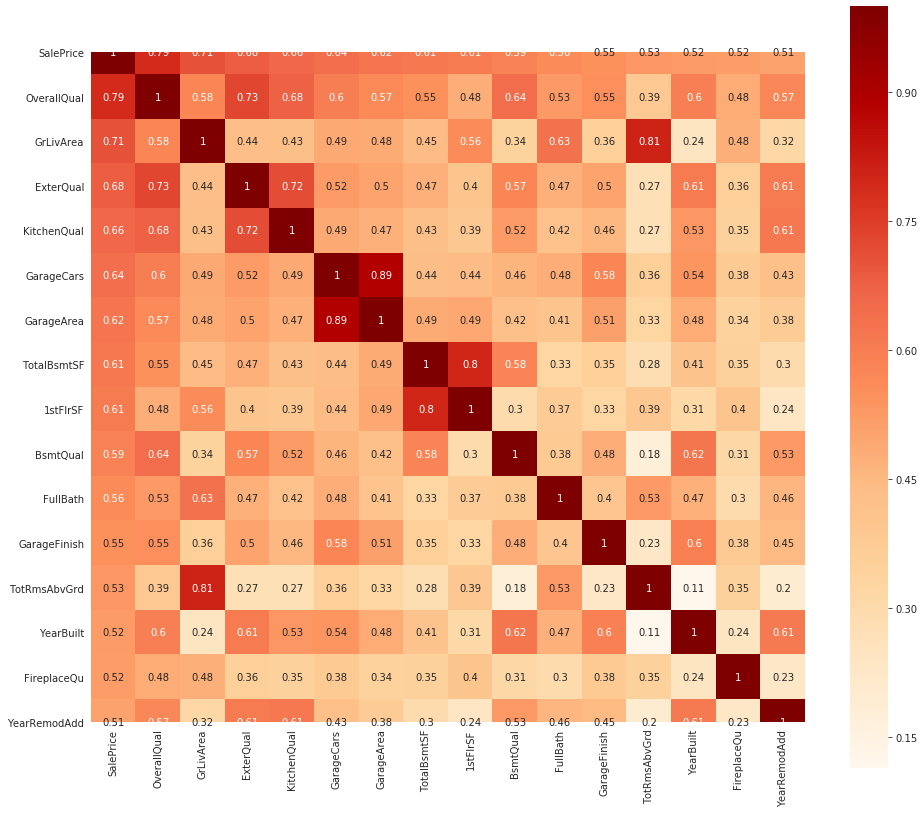

In [69]:
fig, axes = plt.subplots(figsize=(16,14))
sns.heatmap(df[high_corr.index].corr(), cbar=True, annot=True, cmap = 'OrRd', square=True)

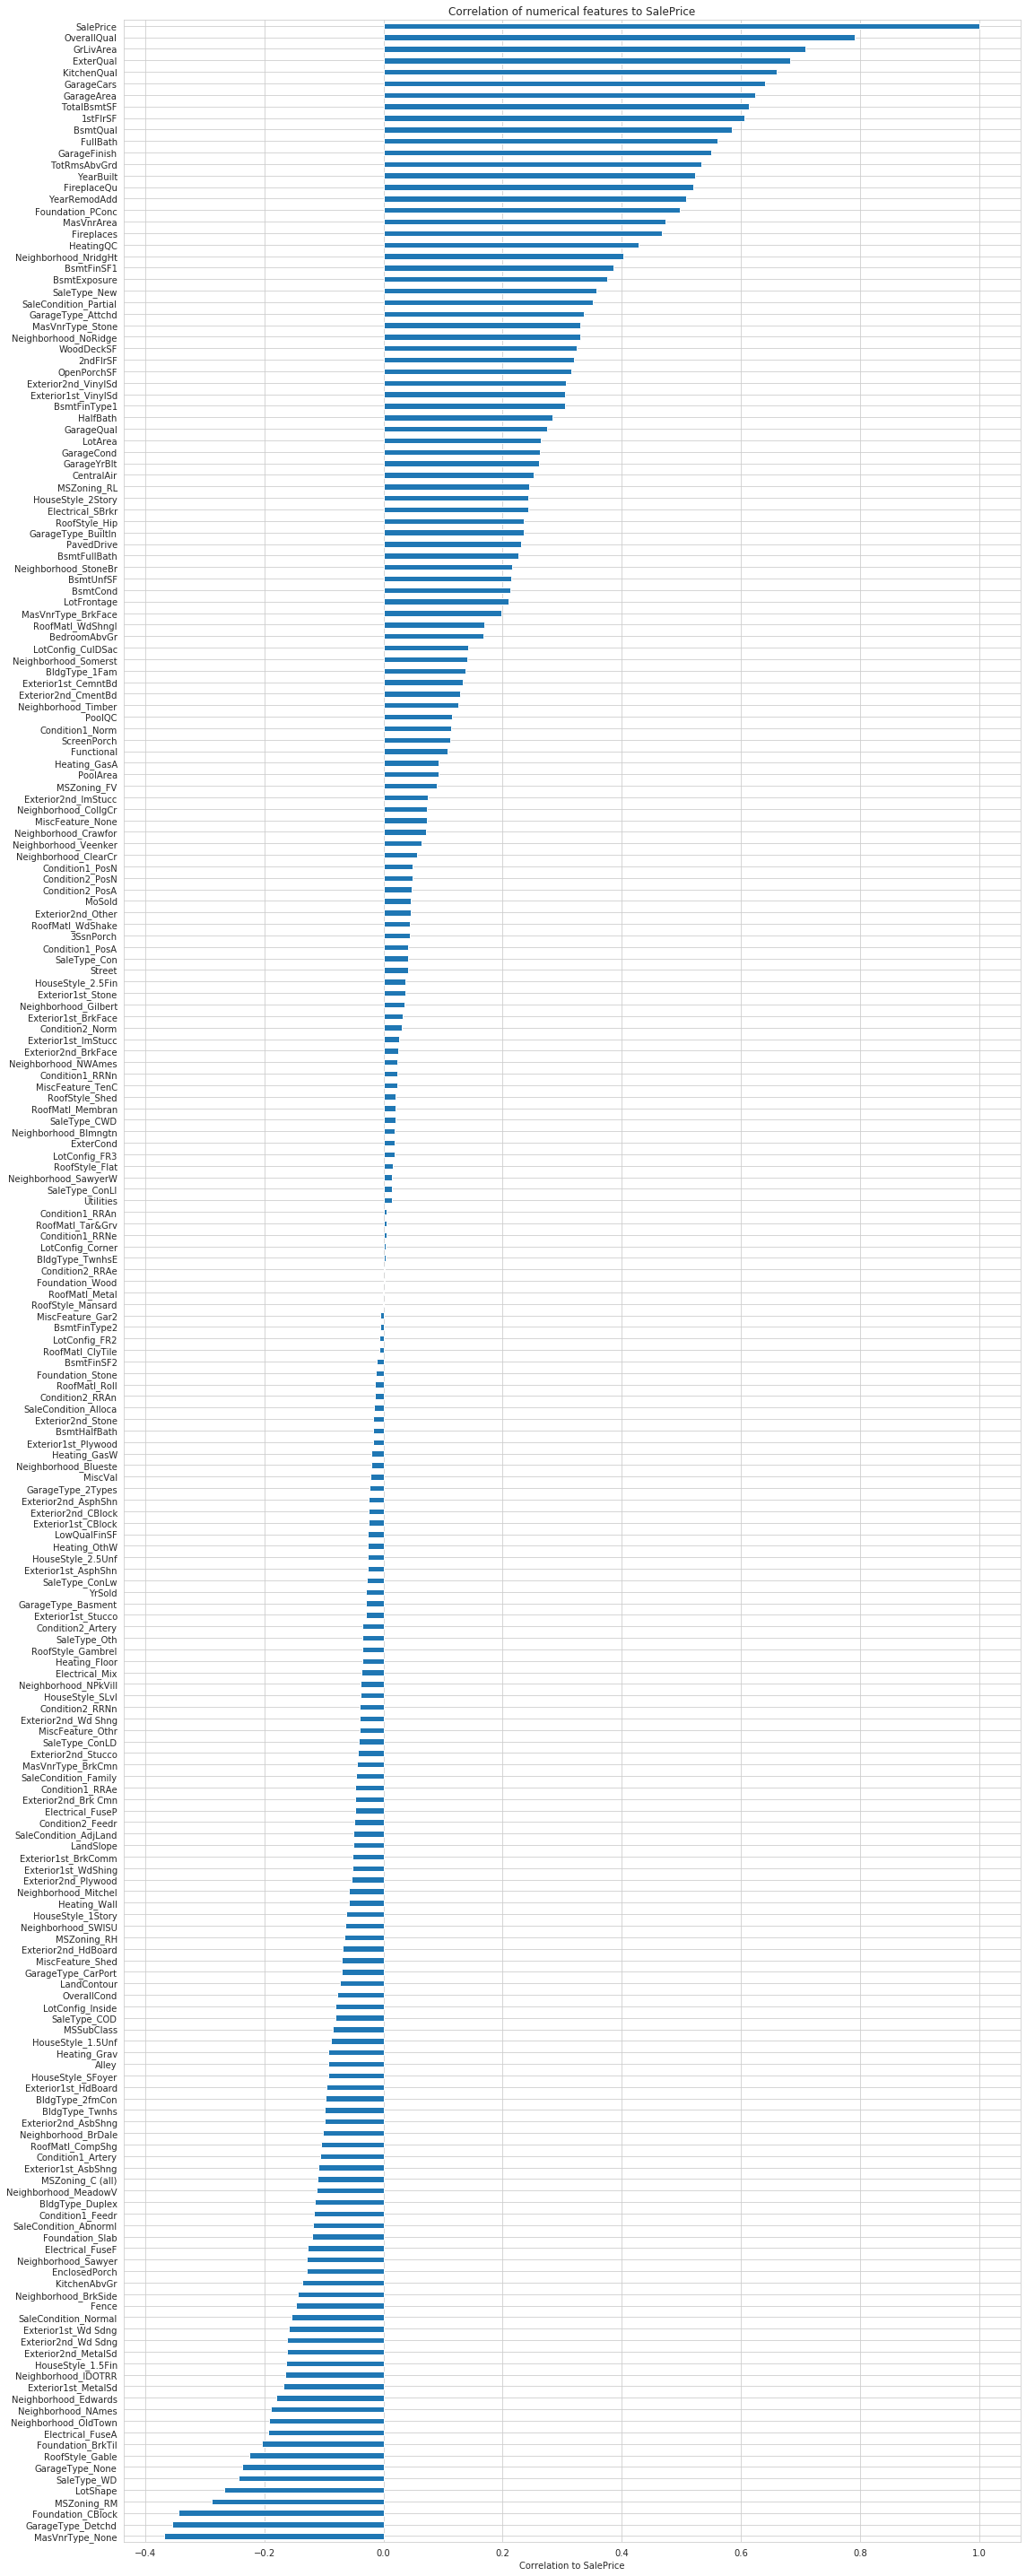

In [70]:
plt.figure(figsize=(16,40));
corr = df.corr()['SalePrice']

# high_corr = df.corr()['SalePrice'][(abs(df.corr()['SalePrice']) > 0.5)].sort_values(ascending = False)
corr.sort_values(ascending=True)[:-1].plot(kind="barh")
plt.title("Correlation of numerical features to SalePrice")
plt.xlabel("Correlation to SalePrice")
plt.tight_layout()
plt.show()

### Basement

In [0]:
df['BsmtSpace'] = df['BsmtQual'] * df['TotalBsmtSF']

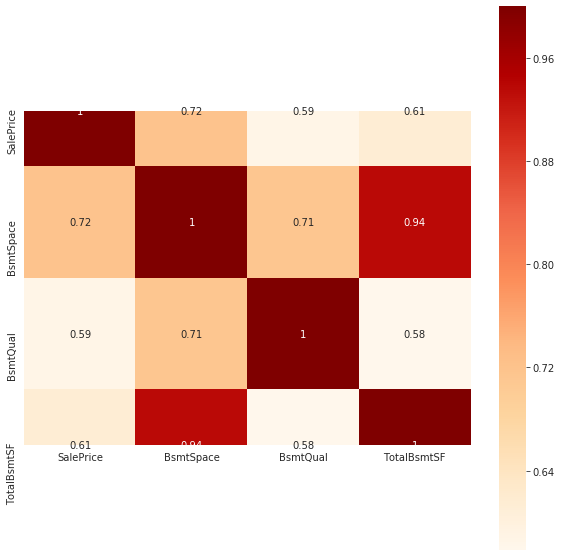

In [72]:
fig, axes = plt.subplots(figsize=(10,10))
sns.heatmap(df[['SalePrice', 'BsmtSpace','BsmtQual', 'TotalBsmtSF']].corr(), cbar=True, annot=True, cmap = 'OrRd', square=True)

### Porch

In [0]:
df['hasScreenPorch'] = df['ScreenPorch'].apply(lambda x: 0 if x > 0 else 1)
df['hasEnclosedPorch'] = df['EnclosedPorch'].apply(lambda x: 0 if x > 0 else 1)
df['hasOpenPorchSF'] = df['OpenPorchSF'].apply(lambda x: 0 if x > 0 else 1)
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch']
df['hasPorch'] = df['TotalPorchSF'].apply(lambda x : 0 if x > 0 else 1)

### Surface Area

In [0]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

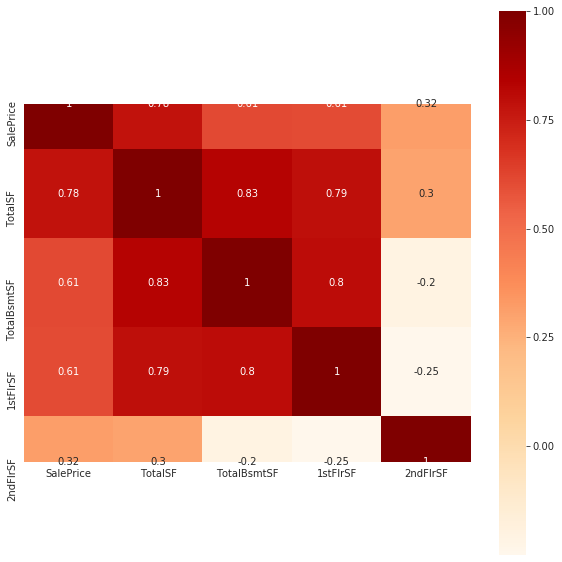

In [75]:
fig, axes = plt.subplots(figsize=(10,10))
sns.heatmap(df[['SalePrice', 'TotalSF','TotalBsmtSF', '1stFlrSF', '2ndFlrSF']].corr(), cbar=True, annot=True, cmap = 'OrRd', square=True)

### has Property

In [0]:
df['hasFireplace'] = df['FireplaceQu'].apply(lambda x : 0 if x == 0 else 1)
df['hasGarage'] = df['GarageArea'].apply(lambda x : 0 if x == 0 else 1)
df['hasBasement'] = df['BsmtExposure'].apply(lambda x : 0 if x == 0 else 1)
df['hasPool'] = df['PoolQC'].apply(lambda x : 0 if x == 0 else 1)
df['hasFence'] = df['Fence'].apply(lambda x : 0 if x == 0 else 1)
df['hasRenovate'] = df ['YearRemodAdd'] - df['YearBuilt']
df['hasRenovate'] = df['hasRenovate'].apply(lambda x: 0 if x == 0 else 1)

### Quality

In [0]:
df['TotalQual'] = df['KitchenQual'] + df['ExterQual'] + df['OverallQual']
df['PaveScore'] = df['PavedDrive'] + df['Alley'] + df['Street']

## Correlation

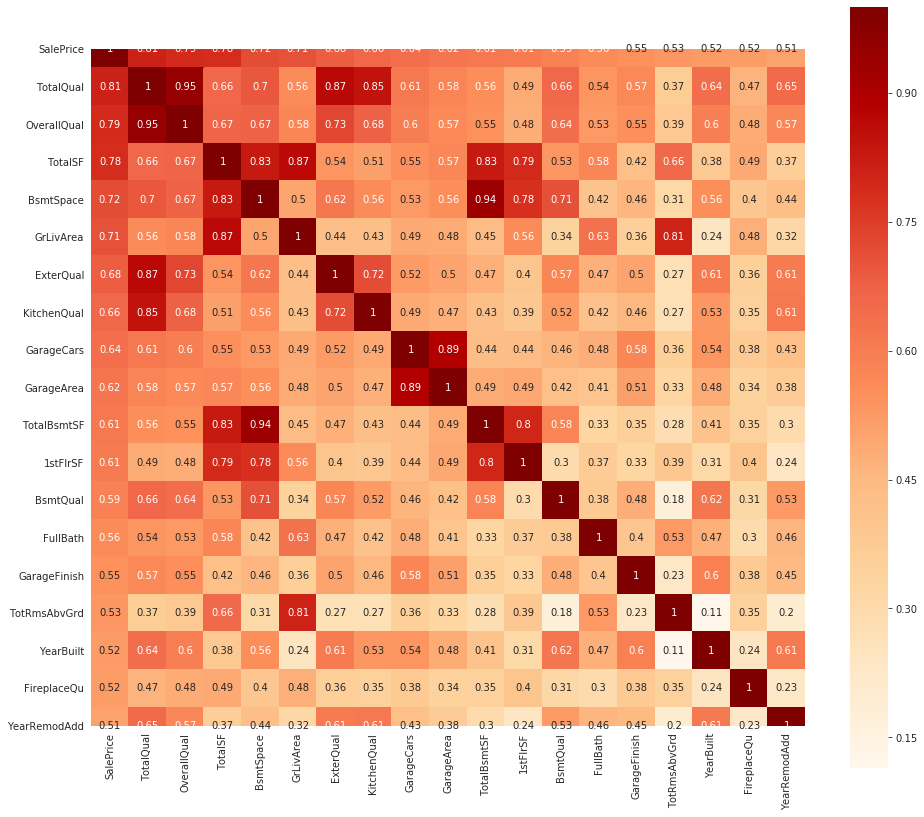

In [78]:
high_corr = df.corr()['SalePrice'][(abs(df.corr()['SalePrice']) > 0.5)].sort_values(ascending = False)
high_corr

fig, axes = plt.subplots(figsize=(16,14))
sns.heatmap(df[high_corr.index].corr(), cbar=True, annot=True, cmap = 'OrRd', square=True)

# Prediction

## Train test split

In [0]:
X_col = df.columns.tolist()
X_col.remove('SalePrice')
y_col = 'SalePrice'

In [0]:
df_train = df[df['SalePrice'].notnull()]
df_test = df[df['SalePrice'].isnull()]

# Import sklearn Library

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.metrics.scorer import neg_mean_squared_error_scorer

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb

## Baseline with Linear Regressor

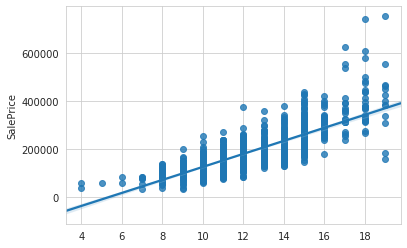

In [82]:
sns.regplot(x = df_train[["TotalQual"]], y = df_train.SalePrice)

In [83]:
X = df_train[df_train["TotalQual"] > 5][["TotalQual"]]
y = df_train[df_train["TotalQual"] > 5].SalePrice
metric = 'neg_mean_squared_log_error'
clf = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log Error")

0.2397 Log Error


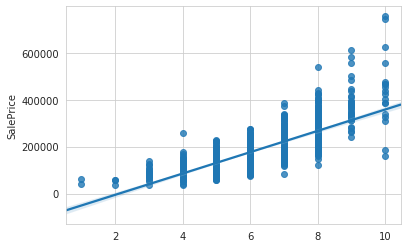

In [84]:
sns.regplot(x = df_train[["OverallQual"]], y = df_train.SalePrice)

In [85]:
X = df_train[df_train["OverallQual"] > 2][["OverallQual"]]
y = df_train[df_train["OverallQual"] > 2].SalePrice
metric = 'neg_mean_squared_log_error'
clf = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log Error")

0.2641 Log Error


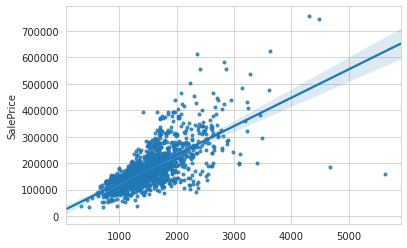

In [86]:
sns.regplot(x = df_train[["GrLivArea"]], y = df_train.SalePrice, marker = '.')

In [87]:
X = df_train[["GrLivArea"]]
y = df_train.SalePrice
metric = 'neg_mean_squared_log_error'
clf = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log Error")

0.2750 Log Error


In [88]:
X = df_train[df_train["GrLivArea"] < 4000][["GrLivArea"]]
y = df_train[df_train["GrLivArea"] < 4000].SalePrice
metric = 'neg_mean_squared_log_error'
clf = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log Error")

0.2715 Log Error


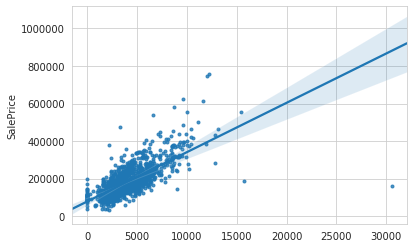

In [89]:
sns.regplot(x = df_train[["BsmtSpace"]], y = df_train.SalePrice, marker = '.')

In [90]:
X = df_train[["BsmtSpace"]]
y = df_train.SalePrice
metric = 'neg_mean_squared_log_error'
clf = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log Error")

0.2792 Log Error


In [91]:
X = df_train[df_train["BsmtSpace"] < 30000][["BsmtSpace"]]
y = df_train[df_train["BsmtSpace"] < 30000].SalePrice
metric = 'neg_mean_squared_log_error'
clf = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log Error")

0.2770 Log Error


In [0]:
high_corr_col = high_corr.index.tolist()
high_corr_col.remove('SalePrice')

In [93]:
X = df_train[high_corr_col].values

y = np.log1p(df_train.SalePrice)
metric = 'neg_mean_squared_error'

clf = make_pipeline(SimpleImputer(), StandardScaler(), LinearRegression())
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log Error")

0.1660 Log Error


# Feature Selection with XGBoost

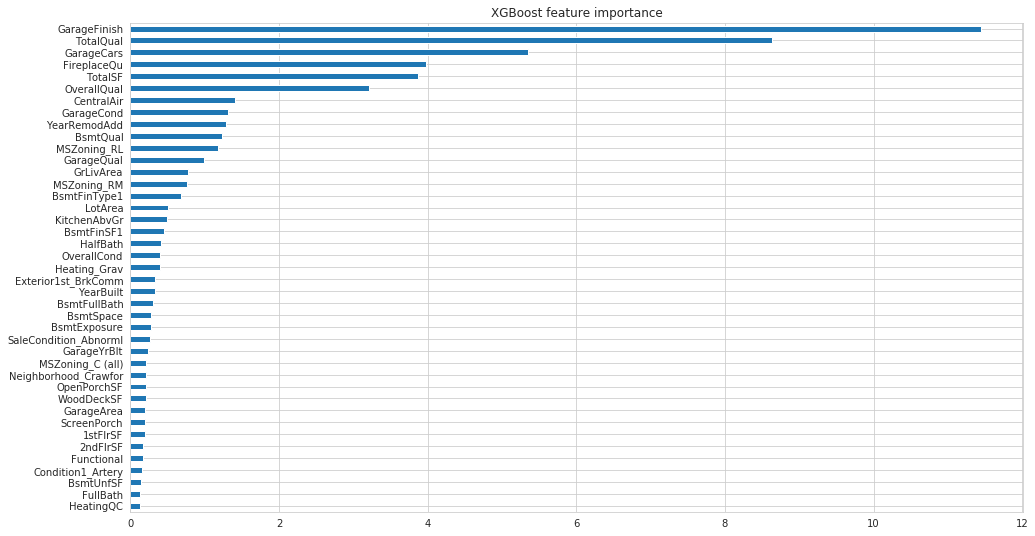

In [94]:
from scipy.stats import skew
from scipy.special import boxcox1p

X = df_train[df_train.GrLivArea < 4000].drop(["SalePrice"], axis=1).copy()
y = np.log1p(df_train[df_train.GrLivArea < 4000].SalePrice)

# again we apply the boxcox transformation
sk = pd.DataFrame(X.iloc[:, :60].skew(), columns=["skewness"])
sk = sk[sk.skewness > .75]
for feature_ in sk.index:
    X[feature_] = boxcox1p(X[feature_], 0.15)

clf = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1)
model = clf.fit(X,y)
score = model.get_booster().get_score(importance_type='gain')

df_gain = pd.DataFrame(score,index=['gain_']).T
df_gain.sort_values("gain_", ascending=True, inplace=True)

plt.figure(figsize=(16,9))
df_gain.iloc[50:, :].gain_.plot(kind="barh")
plt.title(f"XGBoost feature importance")
plt.show()

In [0]:
classifiers = [
               Ridge(), 
               Lasso(), 
               ElasticNet(),
               xgb.XGBRegressor(objective="reg:squarederror"),
]

clf_names = [
            "ridge      ",
            "lasso      ",
            "elastic    ",
            "xgboost    ",
]

# Baseline with every column

In [96]:
X = df_train.drop(["SalePrice"], axis=1)
y = np.log1p(df_train.SalePrice)
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f}")

ridge       0.1424
lasso       0.1963
elastic     0.1886
xgboost     0.1284


In [97]:
X = df_train[df_train.GrLivArea < 4000].drop(["SalePrice"], axis=1)
y = np.log1p(df_train[df_train.GrLivArea < 4000].SalePrice)
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f}")

ridge       0.1183
lasso       0.1666
elastic     0.1568
xgboost     0.1210


# feature selection based on xgboost

In [98]:
X = df_train[df_gain.index.tolist()]
y = np.log1p(df_train.SalePrice)
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f}")

ridge       0.1402
lasso       0.1963
elastic     0.1886
xgboost     0.1305


In [99]:
X = df_train[df_train.GrLivArea < 4000][df_gain.index.tolist()]
y = np.log1p(df_train[df_train.GrLivArea < 4000].SalePrice)
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f}")

ridge       0.1118
lasso       0.1666
elastic     0.1569
xgboost     0.1223


In [0]:
gains = np.arange(0,0.3,0.01)
MSLE = {}

for gain in gains:
    X_gain = df_gain[df_gain['gain_'] > gain].index.tolist()
    X = df_train[df_train.GrLivArea < 4000][X_gain]
    y = np.log1p(df_train[df_train.GrLivArea < 4000].SalePrice)
    metric = 'neg_mean_squared_error'
    
    for clf_name, clf in zip(clf_names, classifiers):
        kfold = KFold(n_splits=5, shuffle=True, random_state=1)
        score = np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean()
        
        if clf_name in MSLE:
            MSLE[clf_name].append(score)
        else:
            MSLE[clf_name] = [] 
            MSLE[clf_name].append(score)

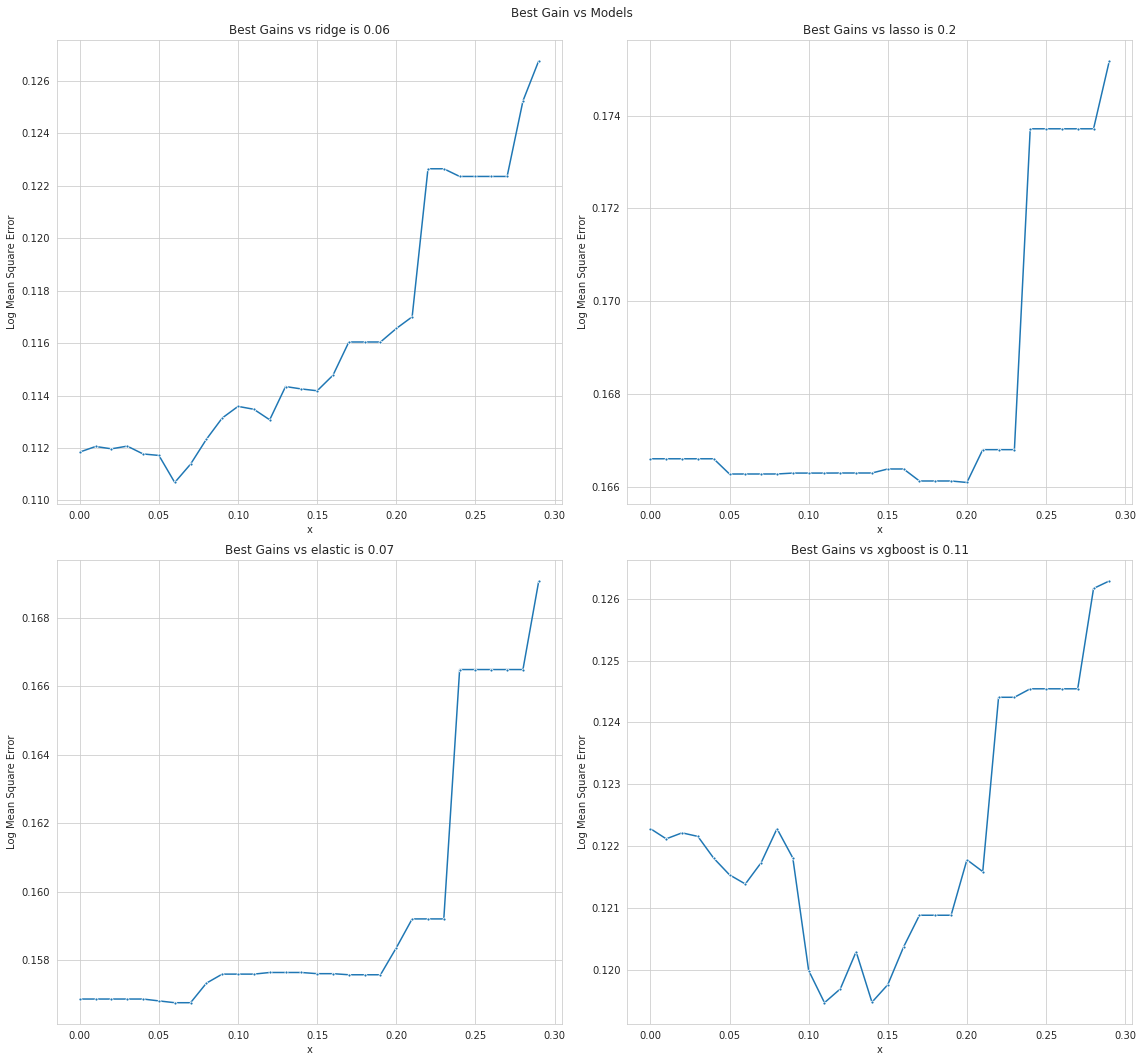

In [101]:
best_gain = {}

fig, ax = plt.subplots(2, 2, figsize=(16,15))

for idx,col in enumerate(MSLE):
    sns.lineplot(np.arange(0,0.3,0.01) , MSLE[col], marker='.', ax=ax[idx//2, idx%2])  
    
    gain = MSLE[col].index(min(MSLE[col]))*0.01
    
    ax[idx//2,idx%2].set_title('Best Gains vs ' + col.strip() + ' is ' + str(gain))
    ax[idx//2,idx%2].set_ylabel('Log Mean Square Error')
    ax[idx//2,idx%2].set_xlabel('x')
    
    best_gain[col.strip()] = gain
    
fig.suptitle('Best Gain vs Models')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

In [102]:
y = np.log1p(df_train[df_train.GrLivArea < 4000].SalePrice)
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    X_gain = df_gain[df_gain['gain_'] > best_gain[clf_name.strip()]].index.tolist()
    X = df_train[df_train.GrLivArea < 4000][X_gain]
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.5f}")

ridge       0.11068
lasso       0.16609
elastic     0.15675
xgboost     0.11946


# Hyperparameter Tuning

In [103]:
best_gain

{'elastic': 0.07, 'lasso': 0.2, 'ridge': 0.06, 'xgboost': 0.11}

## Ridge Regression

In [0]:
X_gain = df_gain[df_gain['gain_'] > best_gain['ridge']].index.tolist()
X = df_train[df_train.GrLivArea < 4000][X_gain]
y = np.log1p(df_train[df_train.GrLivArea < 4000].SalePrice)

###HyperParameter: alpha

In [105]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
metric = 'neg_mean_squared_error'
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]


cv_ridge = [np.sqrt(-cross_val_score(Ridge(alpha = alpha).fit(X, y), X, y, cv=kfold, scoring=metric)).mean()
          for alpha in alphas]
 
print("Smallest MSLE is: ", min(cv_ridge), "")
print("Best Alpha is: ", alphas[cv_ridge.index(min(cv_ridge))], "")

Smallest MSLE is:  0.11026089799544936 
Best Alpha is:  3 


Text(0, 0.5, 'msle')

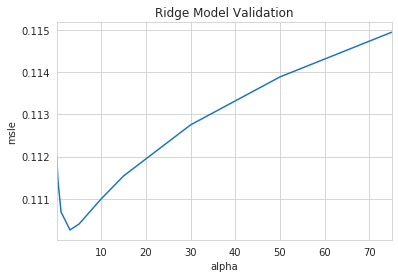

In [106]:
#plot Ridge alpha values
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Model Validation")
plt.xlabel("alpha")
plt.ylabel("msle")

### Predicting test set with ridge regression

In [0]:
ridge = Ridge(alpha = 3).fit(X, y)
df_test['SalePriceRidge'] = ridge.predict(df_test[X_gain])
df_test['SalePriceRidge'] = df_test['SalePriceRidge'].apply(np.expm1)

## Lasso Regression

In [0]:
X_gain = df_gain[df_gain['gain_'] > best_gain['lasso']].index.tolist()
X = df_train[df_train.GrLivArea < 4000][X_gain]
y = np.log1p(df_train[df_train.GrLivArea < 4000].SalePrice)

###HyperParameter: alpha

In [109]:
from sklearn.linear_model import LassoCV
#from previous config
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

#new alpha values
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)

result = np.sqrt(-cross_val_score(model_lasso, X, y, cv=kfold, scoring=metric)).mean()
coef = pd.Series(model_lasso.coef_, index = X.columns)

print(result)

0.11618203820921


In [0]:
df_test['SalePriceLasso'] = model_lasso.predict(df_test[X_gain])
df_test['SalePriceLasso'] = df_test['SalePriceLasso'].apply(np.expm1)

## ElasticNet

###HyperParameter: l1_ratio

In [111]:
X_gain = df_gain[df_gain['gain_'] > best_gain['elastic']].index.tolist()
X = df_train[df_train.GrLivArea < 4000][X_gain]
y = np.log1p(df_train[df_train.GrLivArea < 4000].SalePrice)

cv_model = ElasticNetCV(l1_ratio=np.arange(0.1,0.3,0.01).tolist(), 
                        normalize=True,max_iter=2000, cv=10, n_jobs=-1)

cv_model.fit(X, y)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.11, 0.12, 0.13, 0.13999999999999999,
                       0.14999999999999997, 0.15999999999999998,
                       0.16999999999999998, 0.17999999999999997,
                       0.18999999999999995, 0.19999999999999996,
                       0.20999999999999996, 0.21999999999999995,
                       0.22999999999999995, 0.23999999999999994,
                       0.24999999999999992, 0.2599999999999999,
                       0.2699999999999999, 0.2799999999999999,
                       0.2899999999999999],
             max_iter=2000, n_alphas=100, n_jobs=-1, normalize=True,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

In [112]:
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal l1_ratio: 0.290
Number of iterations 128


In [113]:
print(np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean())

0.12173134113654034


In [0]:
df_test['SalePriceElastic'] = cv_model.predict(df_test[X_gain])
df_test['SalePriceElastic'] = df_test['SalePriceElastic'].apply(np.expm1)

## XGBoost

In [0]:
X_gain = df_gain[df_gain['gain_'] > best_gain['xgboost']].index.tolist()
X = df_train[df_train.GrLivArea < 4000][X_gain]
y = np.log1p(df_train[df_train.GrLivArea < 4000].SalePrice)

In [0]:
xgbreg = xgb.XGBRegressor(objective="reg:squarederror")

In [117]:
print(np.sqrt(-cross_val_score(xgbreg, X, y, cv=kfold, scoring=metric)).mean())

0.11946422835299975


###HyperParameter: learning_rate,reg_alpha,reg_lambda

In [0]:
xgbreg = xgb.XGBRegressor(objective="reg:squarederror",
                             colsample_bytree=0.46, gamma=0.047, 
                             learning_rate=0.04, max_depth=2, 
                             min_child_weight=0.5, n_estimators=2000,
                             reg_alpha=0.46, reg_lambda=0.86,
                             subsample=0.52, random_state=1, n_jobs=-1)

In [119]:
print(np.sqrt(-cross_val_score(xgbreg, X, y, cv=kfold, scoring=metric)).mean())

0.11469551671062932


# Generate CSV for kaggle submission

In [0]:
submission = pd.DataFrame({'Id': submission.Id.values, 'SalePrice': df_test['SalePriceRidge']})
submission.to_csv(f"submission.csv", index=False)

In [0]:
submission = pd.DataFrame({'Id': submission.Id.values, 'SalePrice': df_test['SalePriceLasso']})
submission.to_csv(f"submission.csv", index=False)

In [0]:
submission = pd.DataFrame({'Id': submission.Id.values, 'SalePrice': df_test['SalePriceElastic']})
submission.to_csv(f"submission.csv", index=False)

In [0]:
submission = pd.DataFrame({'Id': submission.Id.values, 'SalePrice': df_test['SalePriceXGB']})
submission.to_csv(f"submission.csv", index=False)